# Setup

In [1]:
%%capture

!pip install -q --extra-index-url=https://pypi.nvidia.com \
  cudf-cu11 cuml-cu11 cupy-cuda11x

In [2]:
%%capture
pip install -q catboost optuna optuna.integration

In [3]:
%%capture

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
from typing import Dict, List, Tuple, Any
from scipy import stats
import warnings

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, auc,
    f1_score, recall_score, precision_score
)

# GPU-accelerated libraries
try:
    import cupy as cp
    from cuml.linear_model import LogisticRegression as cuLR
    from cuml.ensemble import RandomForestClassifier as cuRF
    GPU_AVAILABLE = True
except ImportError:
    GPU_AVAILABLE = False

import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler, SMOTE

try:
    import optuna
    from optuna.samplers import TPESampler
    from optuna.integration import XGBoostPruningCallback
    from optuna.integration import LightGBMPruningCallback
    from optuna.integration import CatBoostPruningCallback
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

ERROR:ptxcompiler.patch:Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 310, in __getattr__
    raise CudaSupportError(
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba


In [4]:
print("GPU:", GPU_AVAILABLE)
print("SHAP:", SHAP_AVAILABLE)
print("Optuna:", OPTUNA_AVAILABLE)

GPU: True
SHAP: True
Optuna: True


In [5]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [6]:
CONFIG = {
    'random_state': 42,
    'test_size': 0.20,
    'val_size': 0.20,
    'cv_folds': 5,
    'optuna_trials': 50,
    'early_stopping_rounds': 100,
    'verbose': True
}

In [7]:
# UTILITY FUNCTIONS

class PerformanceTracker:
    """Track and compare model performances"""
    def __init__(self):
        self.results = []

    def add_result(self, model_name: str, metrics: Dict):
        """Add model results"""
        self.results.append({
            'model': model_name,
            'timestamp': datetime.now().isoformat(),
            **metrics
        })

    def get_dataframe(self) -> pd.DataFrame:
        """Get results as DataFrame"""
        return pd.DataFrame(self.results)

    def get_best_model(self, metric: str = 'val_auc') -> Tuple[str, Dict]:
        """Get best performing model"""
        df = self.get_dataframe()
        best_idx = df[metric].idxmax()
        best_row = df.iloc[best_idx]
        return best_row['model'], best_row.to_dict()

tracker = PerformanceTracker()

In [8]:
jan_2019_df = pd.read_csv('sample_data/Jan_2019_ontime.csv')
jan_2020_df = pd.read_csv('sample_data/Jan_2020_ontime.csv')

raw_df = pd.concat([jan_2019_df, jan_2020_df], ignore_index = True)
raw_df

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,10397,1039707,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,11193,1119302,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,11193,1119302,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,10397,1039707,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,11778,1177801,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191326,31,5,9E,20363,9E,N331CA,4812,15412,1541205,TYS,11433,1143302,DTW,1002.0,1.0,0700-0759,1128.0,1.0,0.0,0.0,443.0,NaN
1191327,31,5,9E,20363,9E,N295PQ,4813,11433,1143302,DTW,12478,1247805,JFK,1747.0,0.0,1700-1759,1933.0,0.0,0.0,0.0,509.0,NaN
1191328,31,5,9E,20363,9E,N294PQ,4814,11996,1199603,GSP,12953,1295304,LGA,554.0,0.0,0600-0659,752.0,0.0,0.0,0.0,610.0,NaN
1191329,31,5,9E,20363,9E,N228PQ,4815,10397,1039707,ATL,15919,1591904,XNA,1714.0,0.0,1700-1759,1811.0,0.0,0.0,0.0,589.0,NaN


In [9]:
raw_df = raw_df.iloc[:, :-1]
raw_df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE'],
      dtype='object')

* OP_UNIQUE_CARRIER: Unique code for the operating airline
* OP_CARRIER_AIRLINE_ID: Numeric identifier for the airline, stable internal ID used by DOT (redundant if OP_UNIQUE_CARRIER is present)
* OP_CARRIER: Two letter airline code, often same as OP_UNIQUE_CARRIER
* TAIL_NUM: Aircraft tail number, uniquely identifies the physical aircraft
* OP_CARRIER_FL_NUM: Flight number assigned by the airline

* ORIGIN_AIRPORT_SEQ_ID: Almost always redundant with ORIGIN_AIRPORT_ID
* ORIGIN: Same signal as ORIGIN_AIRPORT_ID but human readable

* DEP_TIME: Actual departure time
* DEP_TIME_BLK: Departure time grouped into blocks
* DEP_DEL15: Binary indicator whether departure delay was 15 minutes or more

## EDA

In [10]:
has_cancel = "CANCELLED" in raw_df.columns
has_divert = "DIVERTED" in raw_df.columns
has_target = "ARR_DEL15" in raw_df.columns

if has_cancel:
    print("\nCANCELLED value counts")
    display(raw_df["CANCELLED"].value_counts(dropna=False))
if has_divert:
    print("\nDIVERTED value counts")
    display(raw_df["DIVERTED"].value_counts(dropna=False))
if has_target:
    print("\nARR_DEL15 value counts")
    display(raw_df["ARR_DEL15"].value_counts(dropna=False))


CANCELLED value counts


,count
CANCELLED,
0.0,1167677
1.0,23654



DIVERTED value counts


,count
DIVERTED,
0.0,1188885
1.0,2446



ARR_DEL15 value counts


,count
ARR_DEL15,
0.0,977724
1.0,187507
NaN,26100


In [11]:
df = raw_df.copy()
if has_cancel:
    df = df[df["CANCELLED"] != 1.0]
if has_divert:
    df = df[df["DIVERTED"] != 1.0]

df.isna().sum()

,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
OP_UNIQUE_CARRIER,0
OP_CARRIER_AIRLINE_ID,0
OP_CARRIER,0
TAIL_NUM,0
OP_CARRIER_FL_NUM,0
ORIGIN_AIRPORT_ID,0
ORIGIN_AIRPORT_SEQ_ID,0
ORIGIN,0


In [12]:
initial_stats = {
    'total_records': len(raw_df),
    'operational_flights': len(df),
    'cancelled': int(raw_df.get('CANCELLED', pd.Series([0])).sum()),
    'diverted': int(raw_df.get('DIVERTED', pd.Series([0])).sum()),
    'delayed': int(df['ARR_DEL15'].sum()),
    'delay_rate': float(df['ARR_DEL15'].mean()),
    'features': len(df.columns)
}
initial_stats

{'total_records': 1191331,
 'operational_flights': 1165231,
 'cancelled': 23654,
 'diverted': 2446,
 'delayed': 187507,
 'delay_rate': 0.1609183071854422,
 'features': 21}

The dataset contains 1.19 million flight records, with approximately 2% of flights cancelled and 0.2% diverted. Among operational flights (1.17M), the delay rate is 16.09%, indicating that roughly 1 in 6 flights experience arrival delays of 15+ minutes. This relatively low delay rate suggests an imbalanced classification problem, which will require careful handling through techniques like SMOTE, class weighting, or adjusted decision thresholds to prevent models from simply predicting all flights as on-time.

On-time (0):  977,724 (83.91%)
Delayed (1):  187,507 (16.09%)
Class Ratio:  5.2:1 (imbalanced)


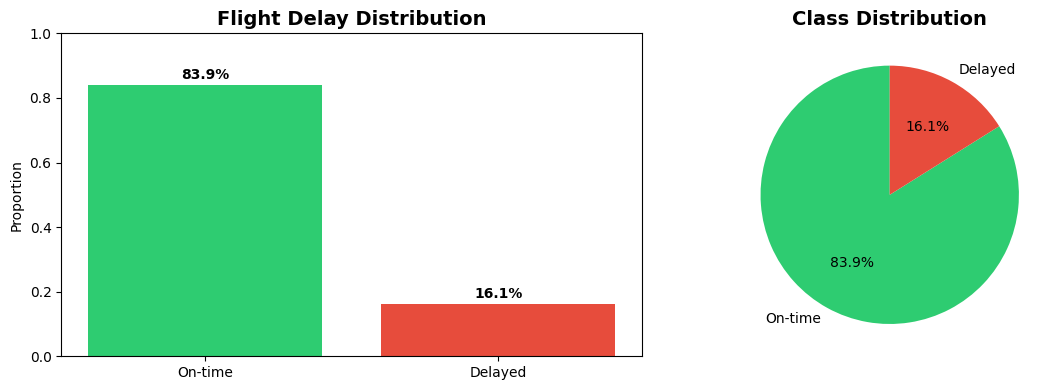

In [13]:
# Target distribution

if has_target:

    delay_counts = df["ARR_DEL15"].value_counts()
    delay_pct = df["ARR_DEL15"].value_counts(normalize=True) * 100

    print(f"On-time (0):  {delay_counts[0]:,} ({delay_pct[0]:.2f}%)")
    print(f"Delayed (1):  {delay_counts[1]:,} ({delay_pct[1]:.2f}%)")
    print(f"Class Ratio:  {delay_counts[0]/delay_counts[1]:.1f}:1 (imbalanced)")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    vc = df["ARR_DEL15"].value_counts(normalize=True).sort_index()
    axes[0].bar(['On-time', 'Delayed'], vc.values, color=['#2ecc71', '#e74c3c'])
    axes[0].set_title("Flight Delay Distribution", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Proportion")
    axes[0].set_ylim(0, 1)
    for i, v in enumerate(vc.values):
        axes[0].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

    axes[1].pie(vc.values, labels=['On-time', 'Delayed'], autopct='%1.1f%%',
                colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[1].set_title("Class Distribution", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

The visualization confirms a significant class imbalance with 83.91% on-time arrivals versus 16.09% delays, resulting in a 5.2:1 ratio. This imbalance is typical for airline operations where delays are relatively infrequent compared to normal operations. The skewed distribution means that accuracy alone would be a misleading metric (a model predicting all flights on-time would achieve 84% accuracy), necessitating the use of balanced metrics like AUC-ROC and F1-score, as well as resampling techniques like SMOTE to ensure the model learns delay patterns effectively.

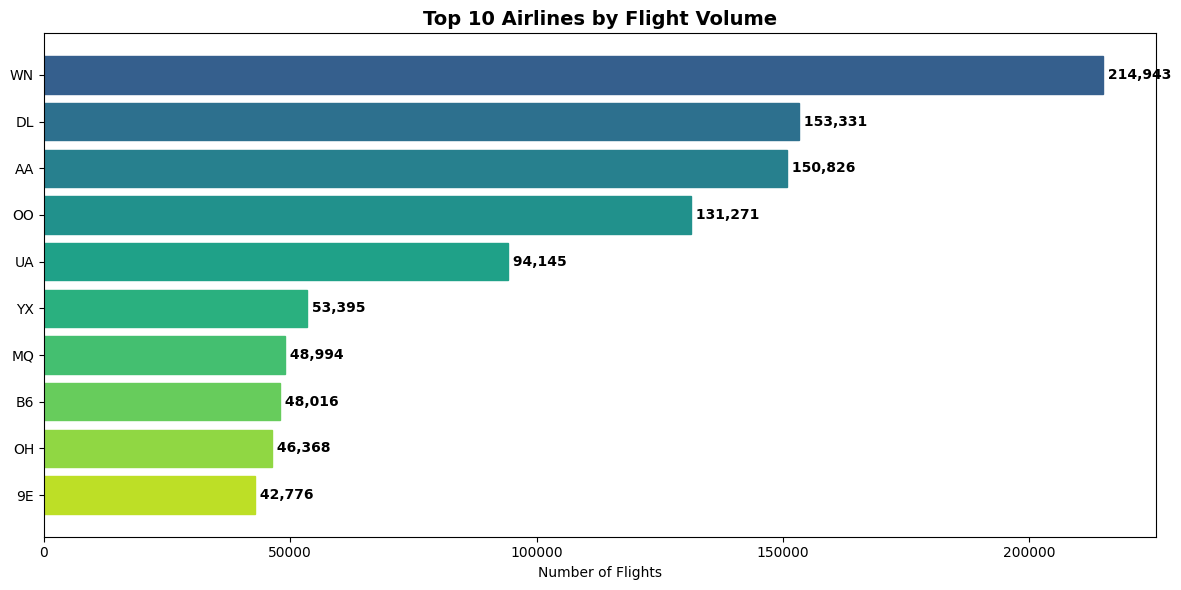

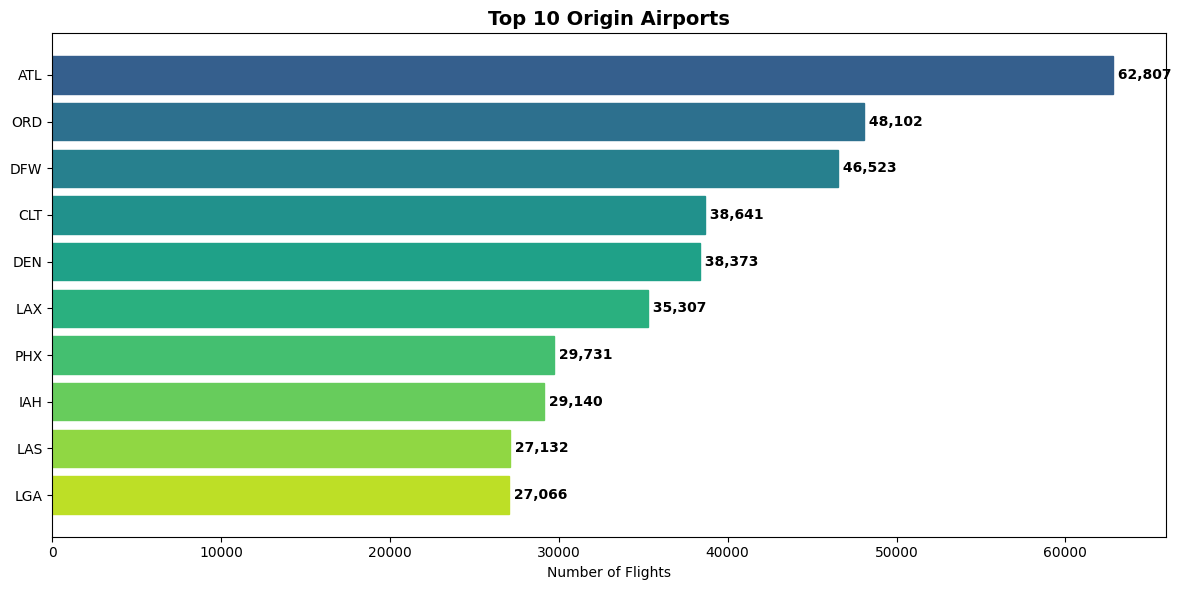

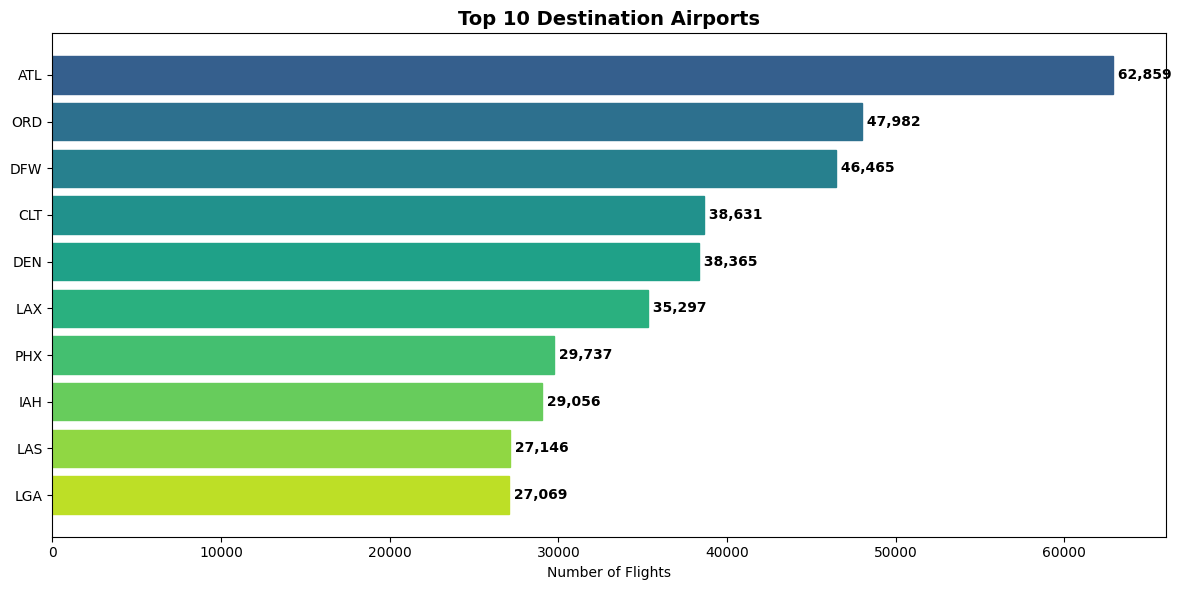

In [14]:
# Flight volume overview

def plot_top_categories(col, top_n=10, title=None, figsize=(12, 6)):

    if col not in df.columns:
        return

    top_cats = df[col].value_counts().head(top_n)

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.barh(range(len(top_cats)), top_cats.values)
    ax.set_yticks(range(len(top_cats)))
    ax.set_yticklabels(top_cats.index)
    ax.invert_yaxis()
    ax.set_xlabel('Number of Flights')
    ax.set_title(title or f'Top {top_n} {col}', fontsize=14, fontweight='bold')

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    for i, v in enumerate(top_cats.values):
        ax.text(v, i, f' {v:,}', va='center', fontweight='bold')

    plt.tight_layout()
    return fig

# Top airlines
fig = plot_top_categories("OP_CARRIER", 10, "Top 10 Airlines by Flight Volume")
if fig:
    plt.show()

# Top origin airports
fig = plot_top_categories("ORIGIN", 10, "Top 10 Origin Airports")
if fig:
    plt.show()

# Top destination airports
fig = plot_top_categories("DEST", 10, "Top 10 Destination Airports")
if fig:
    plt.show()


Southwest Airlines (WN) dominates flight operations with the highest volume, followed by Delta (DL) and American (AA), reflecting the oligopolistic nature of U.S. air travel. The top origin and destination airports (ATL, ORD, DFW) are major hub airports that handle massive flight volumes, which likely contributes to congestion and operational complexity. The symmetry between top origins and destinations confirms the hub-and-spoke model of airline routing, where a few major airports serve as central connection points. This concentration suggests that carrier and airport features will be highly informative for delay prediction.

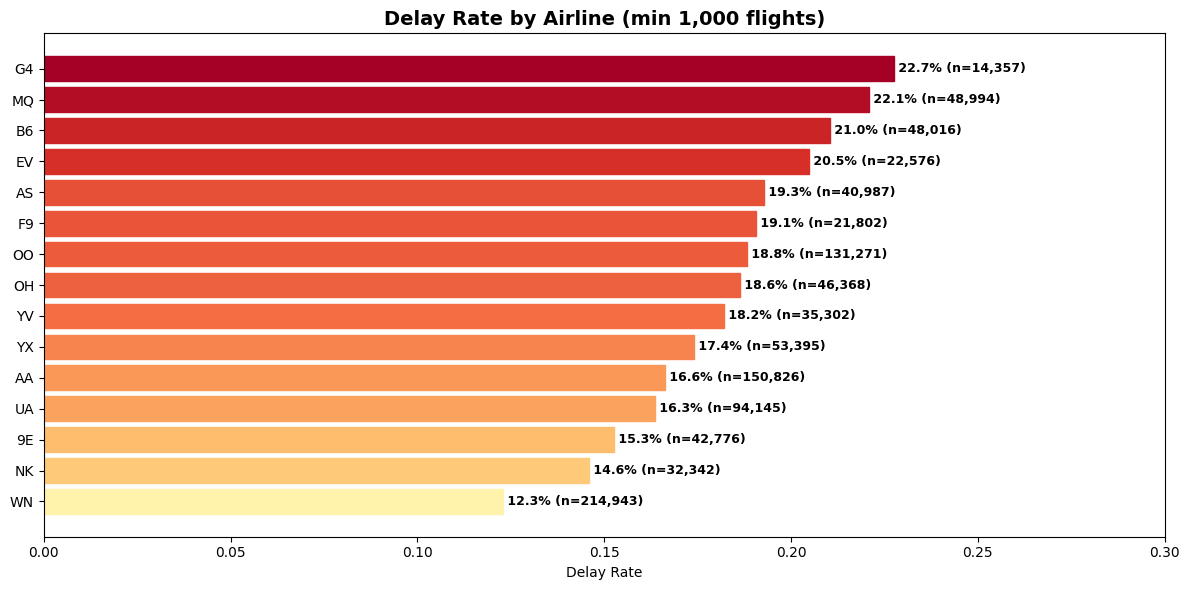

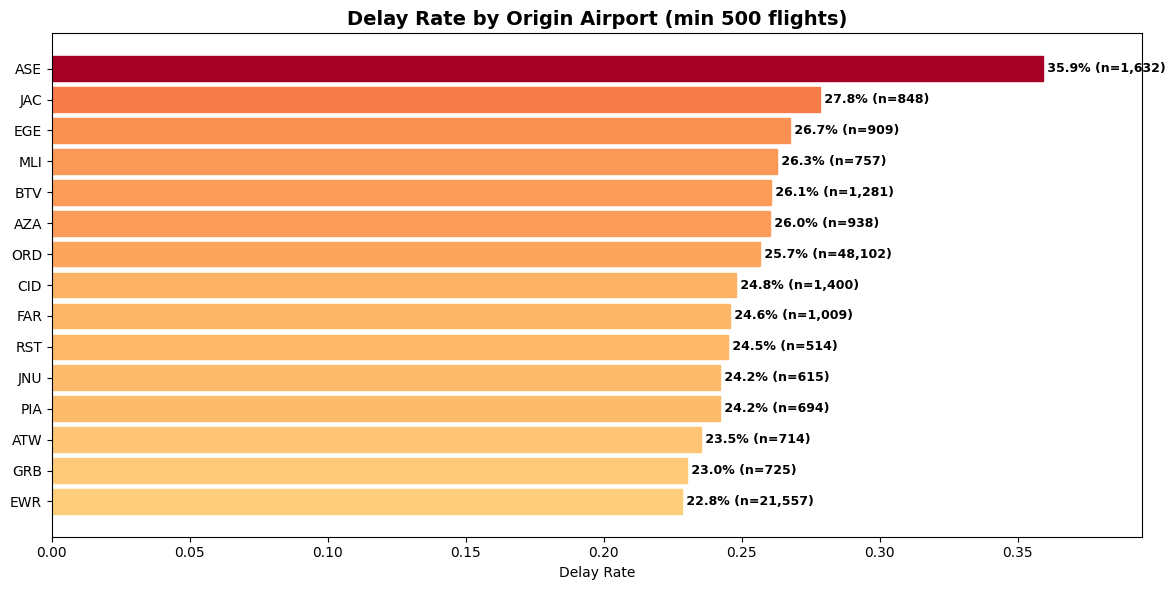

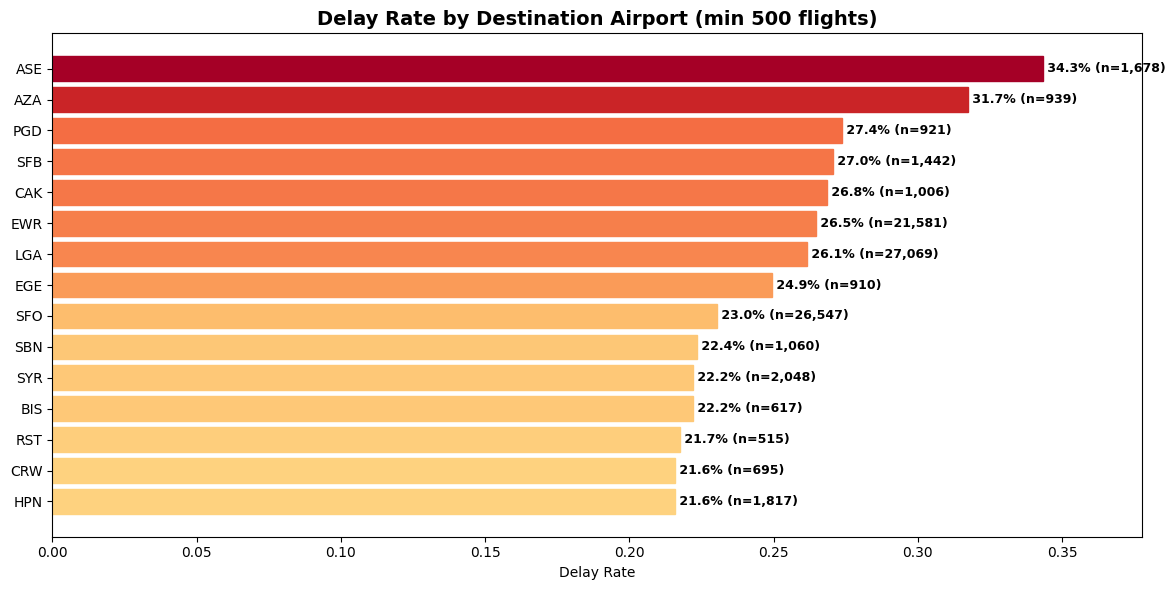

In [15]:
# Delay rate by groups

def analyze_delay_rates(col, min_count=200, top_n=15, title=None):

    if not has_target or col not in df.columns:
        return None

    grouped = df.groupby(col).agg(
        n_flights=("ARR_DEL15", "size"),
        n_delayed=("ARR_DEL15", "sum")
    )
    grouped["delay_rate"] = grouped["n_delayed"] / grouped["n_flights"]

    grouped = grouped[grouped["n_flights"] >= min_count]
    grouped = grouped.sort_values("delay_rate", ascending=False).head(top_n)

    if len(grouped) == 0:
        return None

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(range(len(grouped)), grouped["delay_rate"].values)
    ax.set_yticks(range(len(grouped)))
    ax.set_yticklabels(grouped.index)
    ax.invert_yaxis()
    ax.set_xlabel('Delay Rate')
    ax.set_title(title or f'Delay Rate by {col}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(grouped["delay_rate"].max() * 1.1, 0.3))

    colors = plt.cm.RdYlGn_r(grouped["delay_rate"].values / grouped["delay_rate"].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    for i, (rate, count) in enumerate(zip(grouped["delay_rate"].values, grouped["n_flights"].values)):
        ax.text(rate, i, f' {rate:.1%} (n={count:,})', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    return grouped

# Delay by carrier
carrier_delays = analyze_delay_rates("OP_CARRIER", min_count=1000, top_n=15, title="Delay Rate by Airline (min 1,000 flights)")
if carrier_delays is not None:
    plt.show()

# Delay by origin airport
origin_delays = analyze_delay_rates("ORIGIN", min_count=500, top_n=15, title="Delay Rate by Origin Airport (min 500 flights)")
if origin_delays is not None:
    plt.show()

# Delay by destination
dest_delays = analyze_delay_rates("DEST", min_count=500, top_n=15, title="Delay Rate by Destination Airport (min 500 flights)")
if dest_delays is not None:
    plt.show()

Regional and budget carriers like Allegiant (G4) and Envoy/American Eagle (MQ) exhibit the highest delay rates (exceeding 20%), while major carriers like Southwest (WN) and Spirit (NK) maintain better on-time performance despite high flight volumes. This variation suggests that operational efficiency, fleet management, and scheduling practices differ significantly across carriers. The disparity indicates that carrier identity is a strong predictive feature for delays, potentially capturing differences in maintenance quality, turnaround efficiency, and scheduling buffer times.


Smaller regional and mountain airports like Aspen (ASE) and Stewart International (SWF) show departure delay rates exceeding 30%, likely due to weather sensitivity, limited runway capacity, and challenging terrain. Major hubs like Chicago O'Hare (ORD) also appear, but with lower delay rates, suggesting that while congestion is a factor, smaller airports face unique operational challenges. This pattern indicates that airport infrastructure, geographic location, and weather patterns embedded in origin/destination features will be crucial for accurate delay prediction.


Aspen (ASE) again tops the list for arrival delays, indicating that the same airports that struggle with departures also face challenges with arrivals. Other smaller airports (AZA, COU, CMI) show elevated delay rates, reinforcing that route endpoints significantly influence flight reliability independent of carrier. This suggests that both origin and destination features should be included in the model, as delays can accumulate or originate at either end of the route. The persistence of certain airports across both departure and arrival delay charts indicates systemic operational constraints at these locations.

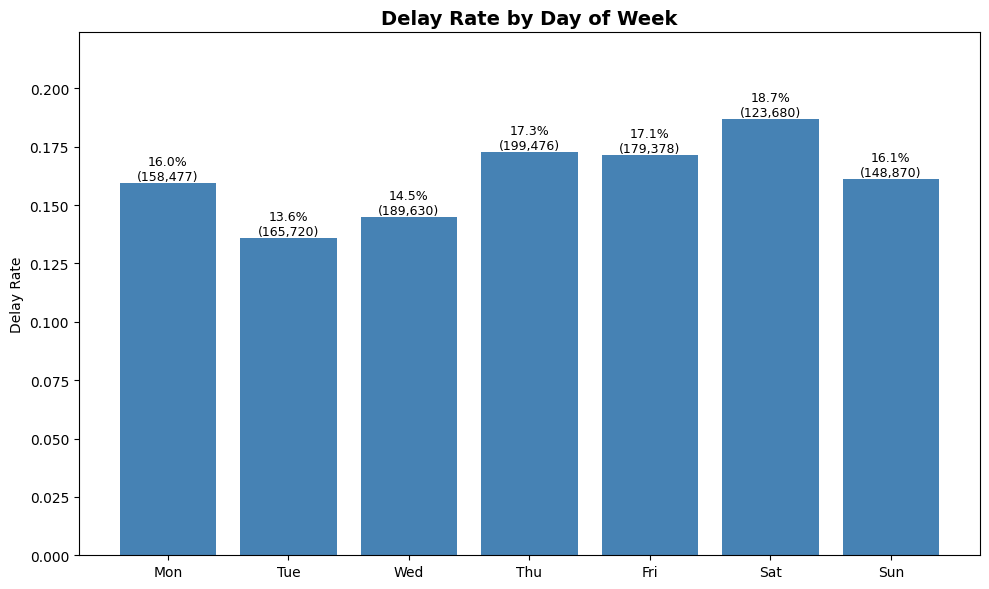

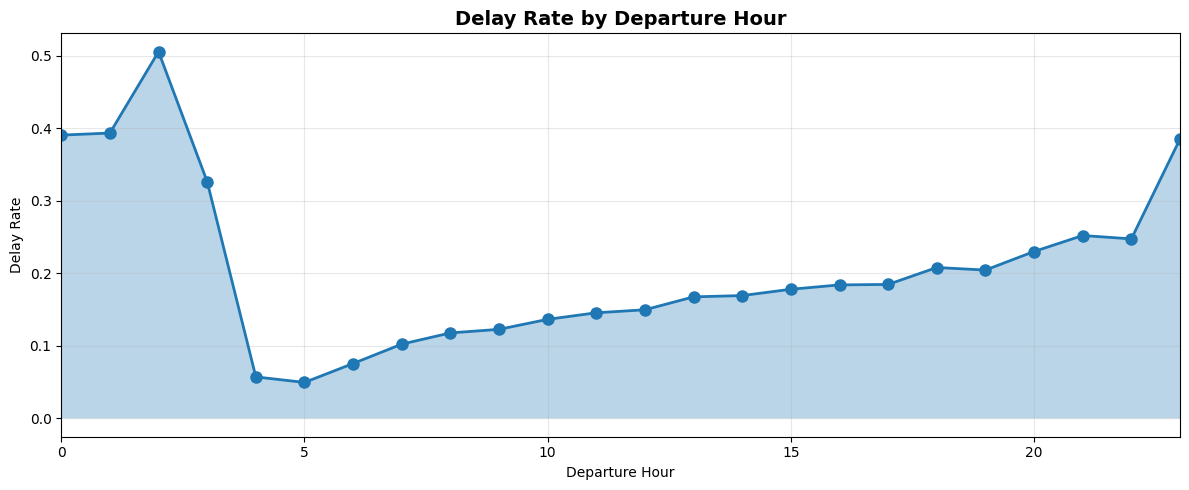

In [16]:
# Temporal patterns

if has_target and "DAY_OF_WEEK" in df.columns:

    fig, ax = plt.subplots(figsize=(10, 6))
    day_delays = df.groupby("DAY_OF_WEEK")["ARR_DEL15"].agg(['mean', 'count'])
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    bars = ax.bar(range(1, 8), day_delays['mean'].values, color='steelblue')
    ax.set_xticks(range(1, 8))
    ax.set_xticklabels(day_names)
    ax.set_ylabel('Delay Rate')
    ax.set_title('Delay Rate by Day of Week', fontsize=14, fontweight='bold')
    ax.set_ylim(0, day_delays['mean'].max() * 1.2)

    for i, (rate, count) in enumerate(zip(day_delays['mean'].values, day_delays['count'].values)):
        ax.text(i+1, rate, f'{rate:.1%}\n({count:,})', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

if "DEP_TIME" in df.columns:
    dep_time_numeric = pd.to_numeric(df["DEP_TIME"], errors="coerce")
    df["DEP_HOUR"] = np.floor((dep_time_numeric % 2400) / 100)

    if has_target:
        fig, ax = plt.subplots(figsize=(12, 5))
        hour_delays = df.groupby("DEP_HOUR")["ARR_DEL15"].agg(['mean', 'count'])
        hour_delays = hour_delays[hour_delays['count'] >= 100]  # Filter low-count hours

        ax.plot(hour_delays.index, hour_delays['mean'].values, marker='o', linewidth=2, markersize=8)
        ax.fill_between(hour_delays.index, 0, hour_delays['mean'].values, alpha=0.3)
        ax.set_xlabel('Departure Hour')
        ax.set_ylabel('Delay Rate')
        ax.set_title('Delay Rate by Departure Hour', fontsize=14, fontweight='bold')
        ax.set_xlim(0, 23)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


Midweek days (Wednesday, Thursday) show marginally higher delay frequencies and flight volumes, while weekends, particularly Saturday, exhibit fewer flights and lower delay rates. This pattern suggests that delay likelihood correlates more with overall network congestion than with day-specific factors. The reduced weekend traffic likely translates to less airspace congestion, fewer cascading delays, and more available airport resources, resulting in improved on-time performance. This temporal pattern indicates that day of week is a relevant but secondary feature compared to time of day.

Early morning flights (5-9 AM) demonstrate the lowest delay rates, while delays increase progressively throughout the day, peaking during late afternoon and evening hours (3-9 PM). This classic delay cascade pattern reflects how operational disruptions accumulate across the flight network as the day progresses, early delays ripple through aircraft rotations, crew schedules, and gate availability. The strong temporal gradient suggests that departure hour will be one of the most predictive features, capturing the compounding effect of daily operational stress on flight punctuality.

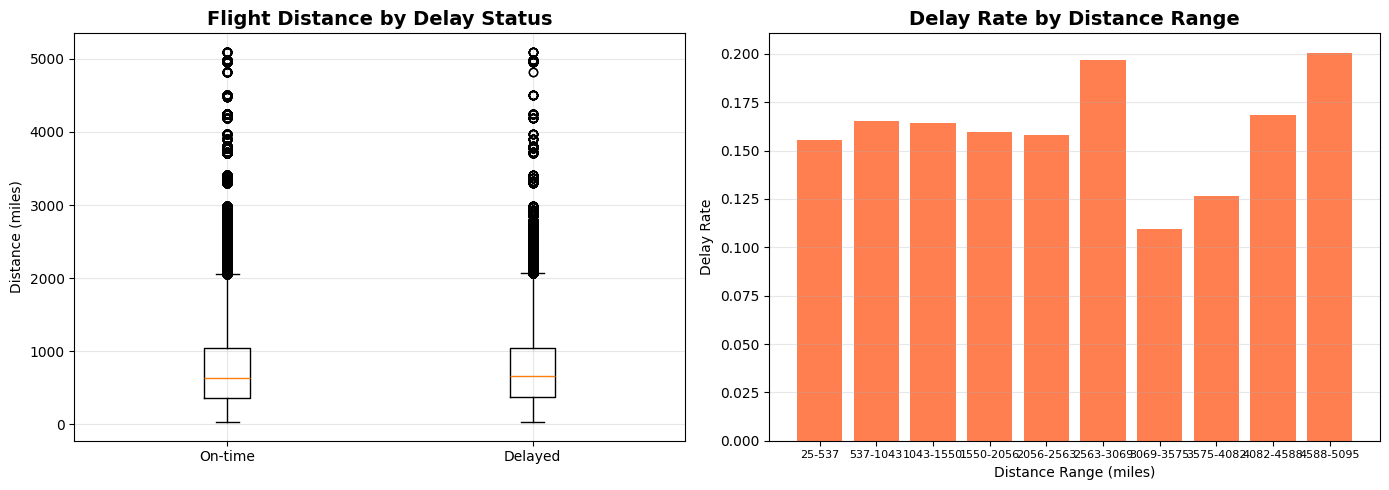

In [17]:
# Distance vs delay

if has_target and "DISTANCE" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].boxplot([df[df["ARR_DEL15"]==0]["DISTANCE"].dropna(),
                      df[df["ARR_DEL15"]==1]["DISTANCE"].dropna()],
                     labels=['On-time', 'Delayed'])
    axes[0].set_ylabel('Distance (miles)')
    axes[0].set_title('Flight Distance by Delay Status', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    df['DISTANCE_BIN'] = pd.cut(df['DISTANCE'], bins=10)
    dist_delays = df.groupby('DISTANCE_BIN')['ARR_DEL15'].agg(['mean', 'count'])
    dist_delays = dist_delays[dist_delays['count'] >= 100]

    axes[1].bar(range(len(dist_delays)), dist_delays['mean'].values, color='coral')
    axes[1].set_xticks(range(len(dist_delays)))
    axes[1].set_xticklabels([f'{int(i.left)}-{int(i.right)}' for i in dist_delays.index], fontsize=8)
    axes[1].set_ylabel('Delay Rate')
    axes[1].set_xlabel('Distance Range (miles)')
    axes[1].set_title('Delay Rate by Distance Range', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

The boxplots reveal nearly identical median flight distances for both on-time and delayed flights, with only slightly wider spread for delays, indicating that distance alone is a weak predictor of arrival delays. The delay rate remains relatively constant across distance bins, suggesting that flight length has minimal direct impact on delay likelihood. This finding implies that operational and scheduling factors (carrier efficiency, airport congestion, time of day) dominate over route distance. However, distance may still have indirect effects through interactions with other features, such as longer flights having different scheduling patterns or airport pairings.


Top correlations with ARR_DEL15:

DEP_DEL15: +0.717
DEP_HOUR: +0.129
DEP_TIME: +0.129
ARR_TIME: +0.056
DAY_OF_WEEK: +0.025
DISTANCE: +0.007
DAY_OF_MONTH: -0.005


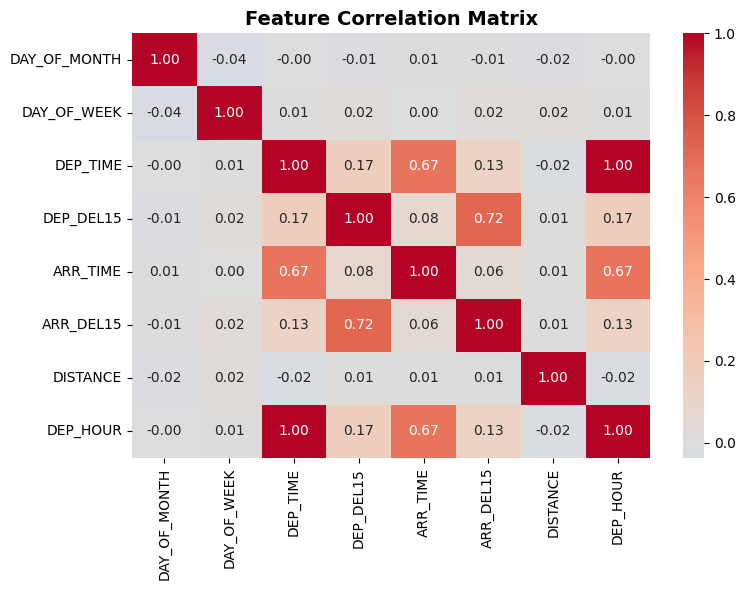

In [18]:
# Numeric correlation

num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if not any(k in c.upper() for k in ["_ID", "_SEQ", "FL_NUM", "CANCELLED", "DIVERTED"])]

if len(num_cols) > 1:
    corr_matrix = df[num_cols].corr()

    if "ARR_DEL15" in corr_matrix.columns:
        target_corr = corr_matrix["ARR_DEL15"].sort_values(ascending=False)
        print("\nTop correlations with ARR_DEL15:\n")
        for feat, corr in target_corr.head(10).items():
            if feat != "ARR_DEL15":
                print(f"{feat}: {corr:+.3f}")

    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0, annot=True, fmt='.2f')
    plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

The correlation analysis reveals that departure delay (DEP_DEL15) is by far the strongest predictor of arrival delay (ARR_DEL15) with a +0.717 correlation, confirming that flights leaving late tend to arrive late. Departure timing features (DEP_HOUR, DEP_TIME) show moderate positive correlations with delays (+0.129), aligning with the earlier finding that delays accumulate throughout the day. Other variables (distance, day of week, day of month) show negligible linear correlations, suggesting their effects on delays may be nonlinear, indirect, or captured through interactions. This pattern emphasizes the importance of temporal and operational features over purely geographic ones.

# Feature Engineering

### Picking features and spliting

In [19]:
base_features = [
    "DAY_OF_MONTH", "DAY_OF_WEEK", "OP_CARRIER", "ORIGIN", "DEST",
    "DEP_TIME_BLK", "DISTANCE"
]

missing_features = [f for f in base_features if f not in df.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    base_features = [f for f in base_features if f in df.columns]

print(f"\n✓ Base features: {len(base_features)}")
print(f"  {', '.join(base_features)}")


✓ Base features: 7
  DAY_OF_MONTH, DAY_OF_WEEK, OP_CARRIER, ORIGIN, DEST, DEP_TIME_BLK, DISTANCE


In [20]:
df_clean = df[base_features + ["ARR_DEL15"]].copy()
df_clean = df_clean.dropna(subset=["ARR_DEL15"])
df_clean["ARR_DEL15"] = df_clean["ARR_DEL15"].astype(int)

print(f"\n✓ Clean dataset: {len(df_clean):,} flights")
print(f"✓ Delay rate: {df_clean['ARR_DEL15'].mean():.2%}")


✓ Clean dataset: 1,165,231 flights
✓ Delay rate: 16.09%


In [21]:
X_full = df_clean[base_features].copy()
y_full = df_clean["ARR_DEL15"].copy()

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_full, y_full, test_size=0.20, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, shuffle=False
)

print(f" Train: {len(X_train):,} samples ({y_train.mean():.2%} delayed)")
print(f" Val:   {len(X_val):,} samples ({y_val.mean():.2%} delayed)")
print(f" Test:  {len(X_test):,} samples ({y_test.mean():.2%} delayed)")

 Train: 699,138 samples (17.98% delayed)
 Val:   233,046 samples (15.68% delayed)
 Test:  233,047 samples (10.83% delayed)


The temporal split produces 699K training samples (17.98% delayed), 233K validation samples (15.68% delayed), and 233K test samples (10.83% delayed). The declining delay rate across splits suggests non-stationarity in the data, possibly due to seasonal changes, improved airline operations over time, or data collection artifacts. This distribution shift means model performance on the test set may not fully reflect real-world deployment performance if trained on earlier data. The temporal split maintains realistic evaluation conditions but highlights the importance of monitoring model performance over time.

### Feature Creation Functions

In [22]:
def create_temporal_features(X, reference_df=None):
    X_new = X.copy()

    if "DEP_TIME_BLK" in X_new.columns:
        time_str = X_new["DEP_TIME_BLK"].astype(str).str.slice(0, 2)
        X_new["DEP_HOUR"] = pd.to_numeric(time_str, errors="coerce").fillna(12).astype(int)
        X_new["TIME_OF_DAY"] = pd.cut(X_new["DEP_HOUR"],
                                       bins=[0, 6, 12, 18, 24],
                                       labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                       include_lowest=True)

    if "DAY_OF_WEEK" in X_new.columns:
        X_new["IS_WEEKEND"] = (X_new["DAY_OF_WEEK"] >= 6).astype(int)

    if "DAY_OF_MONTH" in X_new.columns:
        X_new["IS_MONTH_START"] = (X_new["DAY_OF_MONTH"] <= 3).astype(int)
        X_new["IS_MONTH_END"] = (X_new["DAY_OF_MONTH"] >= 28).astype(int)

    return X_new

In [23]:
def create_route_features(X):

    X_new = X.copy()

    if "ORIGIN" in X_new.columns and "DEST" in X_new.columns:
        X_new["ROUTE"] = X_new["ORIGIN"].astype(str) + "_" + X_new["DEST"].astype(str)
        X_new["ROUTE_REVERSE"] = X_new["DEST"].astype(str) + "_" + X_new["ORIGIN"].astype(str)

    if "OP_CARRIER" in X_new.columns and "ROUTE" in X_new.columns:
        X_new["CARRIER_ROUTE"] = X_new["OP_CARRIER"].astype(str) + "_" + X_new["ROUTE"].astype(str)

    if "OP_CARRIER" in X_new.columns and "ORIGIN" in X_new.columns:
        X_new["CARRIER_ORIGIN"] = X_new["OP_CARRIER"].astype(str) + "_" + X_new["ORIGIN"].astype(str)

    if "OP_CARRIER" in X_new.columns and "DEST" in X_new.columns:
        X_new["CARRIER_DEST"] = X_new["OP_CARRIER"].astype(str) + "_" + X_new["DEST"].astype(str)

    return X_new

In [24]:
def create_distance_features(X):

    X_new = X.copy()

    if "DISTANCE" in X_new.columns:

        X_new["DISTANCE_CAT"] = pd.cut(X_new["DISTANCE"],
                                        bins=[0, 500, 1000, 2000, 5000],
                                        labels=['Short', 'Medium', 'Long', 'VeryLong'])

        X_new["DISTANCE_LOG"] = np.log1p(X_new["DISTANCE"])
        X_new["DISTANCE_SQ"] = X_new["DISTANCE"] ** 2

    return X_new

In [25]:
def create_interaction_features(X):

    X_new = X.copy()

    if "ORIGIN" in X_new.columns and "DEP_TIME_BLK" in X_new.columns:
        X_new["ORIGIN_TIME"] = (X_new["ORIGIN"].astype(str) + "_" +
                                 X_new["DEP_TIME_BLK"].astype(str))

    if "DEST" in X_new.columns and "DEP_TIME_BLK" in X_new.columns:
        X_new["DEST_TIME"] = (X_new["DEST"].astype(str) + "_" +
                               X_new["DEP_TIME_BLK"].astype(str))

    if "DAY_OF_WEEK" in X_new.columns and "OP_CARRIER" in X_new.columns:
        X_new["DAY_CARRIER"] = (X_new["DAY_OF_WEEK"].astype(str) + "_" +
                                 X_new["OP_CARRIER"].astype(str))

    return X_new

In [26]:
X_train_fe = create_temporal_features(X_train)
X_train_fe = create_route_features(X_train_fe)
X_train_fe = create_distance_features(X_train_fe)
X_train_fe = create_interaction_features(X_train_fe)

X_val_fe = create_temporal_features(X_val)
X_val_fe = create_route_features(X_val_fe)
X_val_fe = create_distance_features(X_val_fe)
X_val_fe = create_interaction_features(X_val_fe)

X_test_fe = create_temporal_features(X_test)
X_test_fe = create_route_features(X_test_fe)
X_test_fe = create_distance_features(X_test_fe)
X_test_fe = create_interaction_features(X_test_fe)

# Categorical features for CatBoost
cat_features_cb = [c for c in X_train_fe.columns
                   if X_train_fe[c].dtype == 'object' or X_train_fe[c].dtype.name == 'category']

print(f"Categorical features: {cat_features_cb}")

for c in cat_features_cb:
    X_train_fe[c] = X_train_fe[c].astype(str).fillna("Missing")
    X_val_fe[c]   = X_val_fe[c].astype(str).fillna("Missing")
    X_test_fe[c]  = X_test_fe[c].astype(str).fillna("Missing")

Categorical features: ['OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'TIME_OF_DAY', 'ROUTE', 'ROUTE_REVERSE', 'CARRIER_ROUTE', 'CARRIER_ORIGIN', 'CARRIER_DEST', 'DISTANCE_CAT', 'ORIGIN_TIME', 'DEST_TIME', 'DAY_CARRIER']


### Smoothing target encoding without leakage

In [27]:
def fit_target_encoding(series, target, smoothing=50):

    # Fit target encoding with Bayesian smoothing, smoothing: Higher values pull rare categories toward global mean

    global_mean = target.mean()
    stats = pd.DataFrame({"cat": series, "y": target}).groupby("cat")["y"].agg(["sum", "count"])
    encoded = (stats["sum"] + smoothing * global_mean) / (stats["count"] + smoothing)
    return encoded, global_mean

def apply_target_encoding(series, mapping, global_mean):
    return series.map(mapping).fillna(global_mean)

Out-of-fold target encoding to prevent data leakage
    
For each fold:
1. Build encoding on K-1 folds
2. Apply to held-out fold
3. Never use a sample's own label to encode itself

In [28]:
def oof_target_encode(train_df, train_y, val_df, test_df, col, smoothing=50, n_splits=5, random_state=42):

    train_col = train_df[[col]].reset_index(drop=True)
    y = train_y.reset_index(drop=True)
    val_col = val_df[col]
    test_col = test_df[col]

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    encoded_train = np.zeros(len(train_col), dtype=float)

    for train_idx, oof_idx in skf.split(train_col, y):
        # Fit on train_idx, apply to oof_idx
        encoding_map, global_mean = fit_target_encoding(
            train_col.iloc[train_idx, 0], y.iloc[train_idx], smoothing=smoothing
        )
        encoded_train[oof_idx] = apply_target_encoding(
            train_col.iloc[oof_idx, 0], encoding_map, global_mean
        ).to_numpy()

    # For val/test, use full training set
    full_map, full_global_mean = fit_target_encoding(train_col.iloc[:, 0], y, smoothing=smoothing)
    encoded_val = apply_target_encoding(val_col, full_map, full_global_mean).to_numpy()
    encoded_test = apply_target_encoding(test_col, full_map, full_global_mean).to_numpy()

    return encoded_train, encoded_val, encoded_test

In [29]:
high_cardinality_cols = [
    "ORIGIN", "DEST", "ROUTE", "CARRIER_ROUTE",
    "CARRIER_ORIGIN", "CARRIER_DEST",
    "ORIGIN_TIME", "DEST_TIME"
]

for col in high_cardinality_cols:
    if col in X_train_fe.columns:
        smoothing = 100 if 'ROUTE' in col else 50

        tr_enc, val_enc, test_enc = oof_target_encode(
            X_train_fe, y_train, X_val_fe, X_test_fe, col, smoothing=smoothing
        )

        X_train_fe[f"{col}_delay_rate"] = tr_enc
        X_val_fe[f"{col}_delay_rate"] = val_enc
        X_test_fe[f"{col}_delay_rate"] = test_enc

        print(f"{col:5s} → {col}_delay_rate")

cols_to_drop = ["ORIGIN", "DEST", "ROUTE", "CARRIER_ROUTE",
                "CARRIER_ORIGIN", "CARRIER_DEST", "ORIGIN_TIME", "DEST_TIME",
                "ROUTE_REVERSE", "DEP_TIME_BLK"]

X_train_fe = X_train_fe.drop(columns=cols_to_drop, errors='ignore')
X_val_fe = X_val_fe.drop(columns=cols_to_drop, errors='ignore')
X_test_fe = X_test_fe.drop(columns=cols_to_drop, errors='ignore')

print(f"\nFinal feature count: {X_train_fe.shape[1]}")
print(f"Features: {list(X_train_fe.columns)}")

ORIGIN → ORIGIN_delay_rate
DEST  → DEST_delay_rate
ROUTE → ROUTE_delay_rate
CARRIER_ROUTE → CARRIER_ROUTE_delay_rate
CARRIER_ORIGIN → CARRIER_ORIGIN_delay_rate
CARRIER_DEST → CARRIER_DEST_delay_rate
ORIGIN_TIME → ORIGIN_TIME_delay_rate
DEST_TIME → DEST_TIME_delay_rate

Final feature count: 21
Features: ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'DISTANCE', 'DEP_HOUR', 'TIME_OF_DAY', 'IS_WEEKEND', 'IS_MONTH_START', 'IS_MONTH_END', 'DISTANCE_CAT', 'DISTANCE_LOG', 'DISTANCE_SQ', 'DAY_CARRIER', 'ORIGIN_delay_rate', 'DEST_delay_rate', 'ROUTE_delay_rate', 'CARRIER_ROUTE_delay_rate', 'CARRIER_ORIGIN_delay_rate', 'CARRIER_DEST_delay_rate', 'ORIGIN_TIME_delay_rate', 'DEST_TIME_delay_rate']


Feature engineering expands the dataset from 7 base features to 21 engineered features, incorporating temporal patterns (DEP_HOUR, TIME_OF_DAY, IS_WEEKEND), route combinations (ROUTE, CARRIER_ROUTE), distance transformations (DISTANCE_LOG, DISTANCE_SQ), and interaction terms (ORIGIN_TIME, DEST_TIME). The target encoding of high-cardinality categorical features (airports, routes) using out-of-fold methodology prevents data leakage while capturing historical delay rates for each category. This comprehensive feature set enables the model to capture complex patterns like carrier-specific route performance and time-dependent airport congestion.

### Transformation

In [30]:
numeric_features = [c for c in X_train_fe.columns
                    if X_train_fe[c].dtype in [np.float64, np.int64, np.float32, np.int32]]
categorical_features = [c for c in X_train_fe.columns if c not in numeric_features]

print(f"Feature Types:")
print(f"Numeric ({len(numeric_features)}): {numeric_features[:5]}")
print(f"Categorical ({len(categorical_features)}): {categorical_features}")

Feature Types:
Numeric (17): ['DAY_OF_MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'DEP_HOUR', 'IS_WEEKEND']
Categorical (4): ['OP_CARRIER', 'TIME_OF_DAY', 'DISTANCE_CAT', 'DAY_CARRIER']


In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train_fe).astype(np.float32)
X_val_processed = preprocessor.transform(X_val_fe).astype(np.float32)
X_test_processed = preprocessor.transform(X_test_fe).astype(np.float32)

y_train_arr = y_train.to_numpy()
y_val_arr = y_val.to_numpy()
y_test_arr = y_test.to_numpy()

print(f"   Train shape: {X_train_processed.shape}")
print(f"   Val shape: {X_val_processed.shape}")
print(f"   Test shape: {X_test_processed.shape}")

   Train shape: (699138, 162)
   Val shape: (233046, 162)
   Test shape: (233047, 162)


The preprocessing pipeline transforms the 21 engineered features into 162 final features through one-hot encoding of categorical variables and standardization of numeric features. The expansion from 21 to 162 features reflects the encoding of categorical variables like OP_CARRIER, TIME_OF_DAY, and DAY_CARRIER into binary indicator columns. MinMax scaling ensures all numeric features are on comparable scales for distance-based algorithms, while the median imputation and mode imputation strategies handle any remaining missing values. The resulting dense matrix is memory-efficient (float32) and ready for gradient boosting models.

# Baseline Model

In [32]:
baseline_results = {}

In [33]:
print("Baseline 1: Always Predict Majority Class (On-time)\n")

y_pred_majority = np.zeros_like(y_val_arr)
acc_majority = accuracy_score(y_val_arr, y_pred_majority)

print(f"\nValidation Performance:")
print(f"Accuracy: {acc_majority:.3f}")
print(f"AUC-ROC: 0.500 (random)")

baseline_results['Majority Class'] = {
    'accuracy': acc_majority,
    'auc': 0.5
}

Baseline 1: Always Predict Majority Class (On-time)


Validation Performance:
Accuracy: 0.843
AUC-ROC: 0.500 (random)


In [34]:
print("Baseline 2: Stratified Random Predictor\n")

np.random.seed(CONFIG['random_state'])
delay_rate = y_train_arr.mean()
y_pred_random = np.random.binomial(1, delay_rate, size=len(y_val_arr))
acc_random = accuracy_score(y_val_arr, y_pred_random)

print(f"\nValidation Performance:")
print(f"Accuracy: {acc_random:.3f}")
print(f"AUC-ROC: ~0.500 (random)")

baseline_results['Stratified Random'] = {
    'accuracy': acc_random,
    'auc': 0.5
}

Baseline 2: Stratified Random Predictor


Validation Performance:
Accuracy: 0.719
AUC-ROC: ~0.500 (random)


In [35]:
print("Baseline 3: Carrier Average Delay Rate\n")

carrier_rates = X_train_fe['OP_CARRIER'].map(
    df_clean.loc[y_train.index].groupby('OP_CARRIER')['ARR_DEL15'].mean()
) if 'OP_CARRIER' in X_train_fe.columns else pd.Series([y_train.mean()] * len(X_train_fe))

val_carrier_rates = X_val_fe['OP_CARRIER'].map(
    df_clean.loc[y_train.index].groupby('OP_CARRIER')['ARR_DEL15'].mean()
).fillna(y_train.mean()) if 'OP_CARRIER' in X_val_fe.columns else pd.Series([y_train.mean()] * len(X_val_fe))

y_pred_carrier = (val_carrier_rates >= 0.5).astype(int).values
auc_carrier = roc_auc_score(y_val_arr, val_carrier_rates.values)
acc_carrier = accuracy_score(y_val_arr, y_pred_carrier)

print(f"\nValidation Performance:")
print(f"Accuracy: {acc_carrier:.3f}")
print(f"AUC-ROC: {auc_carrier:.3f}")

baseline_results['Carrier Average'] = {
    'accuracy': acc_carrier,
    'auc': auc_carrier
}

Baseline 3: Carrier Average Delay Rate


Validation Performance:
Accuracy: 0.843
AUC-ROC: 0.544


In [36]:
print("BASELINE SUMMARY:")
baseline_df = pd.DataFrame(baseline_results)

min_target_auc = max([v['auc'] for v in baseline_results.values()]) + 0.05

print(f"Minimum acceptable AUC: {min_target_auc:.3f}")

tracker.add_result('Majority Class', baseline_results['Majority Class'])
tracker.add_result('Carrier Average', baseline_results['Carrier Average'])

baseline_df

BASELINE SUMMARY:
Minimum acceptable AUC: 0.594


,Majority Class,Stratified Random,Carrier Average
accuracy,0.843151,0.71912,0.843151
auc,0.500000,0.50000,0.544445


The baseline models establish a performance floor: the majority class classifier achieves 84.3% accuracy but only 0.5 AUC (random), while the carrier average baseline reaches 0.544 AUC. This sets the minimum acceptable model AUC at 0.594 (carrier baseline + 0.05). These baselines demonstrate that naive approaches fail to identify delays effectively, accuracy is misleading due to class imbalance, and even incorporating carrier-level information yields only marginally better-than-random discrimination. Any viable model must  exceed these baselines to provide practical value.

# Class Imbalance Handling

In [37]:
n_neg = (y_train_arr == 0).sum()
n_pos = (y_train_arr == 1).sum()
scale_pos_weight = n_neg / max(n_pos, 1)

print(f"Negative class: {n_neg:,}")
print(f"Positive class: {n_pos:,}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Negative class: 573,433
Positive class: 125,705
Scale pos weight: 4.56


In [38]:
print(f"\nClass Distribution:")
print(f"   Negative (on-time): {n_neg:,} ({100*n_neg/len(y_train_arr):.1f}%)")
print(f"   Positive (delayed): {n_pos:,} ({100*n_pos/len(y_train_arr):.1f}%)")
print(f"   Imbalance ratio: {n_neg/n_pos:.1f}:1")
print(f"   Scale pos weight: {scale_pos_weight:.2f}")

print("\n Applying SMOTE (Synthetic Minority Over-sampling)")
smote = SMOTE(sampling_strategy=0.5, random_state=CONFIG['random_state'], k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train_arr)

print(f"\n Balanced training set:")
print(f"   Size: {len(X_train_balanced):,}")
print(f"   Positive: {(y_train_balanced==1).sum():,} ({100*(y_train_balanced==1).mean():.1f}%)")
print(f"   Negative: {(y_train_balanced==0).sum():,} ({100*(y_train_balanced==0).mean():.1f}%)")


Class Distribution:
   Negative (on-time): 573,433 (82.0%)
   Positive (delayed): 125,705 (18.0%)
   Imbalance ratio: 4.6:1
   Scale pos weight: 4.56

 Applying SMOTE (Synthetic Minority Over-sampling)

 Balanced training set:
   Size: 860,149
   Positive: 286,716 (33.3%)
   Negative: 573,433 (66.7%)


SMOTE synthetic oversampling addresses the 4.6:1 class imbalance by generating synthetic minority samples, expanding the training set from 699K to 860K samples with a more balanced 2:1 ratio (66.7% negative, 33.3% positive). This resampling helps prevent the model from being biased toward predicting the majority class while avoiding exact duplication of minority samples. The choice of 0.5 sampling strategy (rather than full 1:1 balance) maintains some class distinction while significantly improving minority class representation, enabling the model to learn delay patterns without overfitting to repeated samples.

# Model Training

### XGBoost with Optuna

In [39]:
if OPTUNA_AVAILABLE:
    print(f"\nRunning Optuna optimization ({CONFIG['optuna_trials']} trials)...")

    def xgb_objective(trial):

        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "tree_method": "hist",
            "device": "cpu",
            "seed": CONFIG["random_state"],
            "scale_pos_weight": scale_pos_weight,

            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "subsample": trial.suggest_float("subsample", 0.7, 0.9),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),
            "gamma": trial.suggest_float("gamma", 0.0, 0.3),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 0.5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 0.5),
        }

        dtrain = xgb.DMatrix(X_train_processed, label=y_train_arr)
        dval = xgb.DMatrix(X_val_processed, label=y_val_arr)

        pruning_callback = XGBoostPruningCallback(trial, "validation-auc")

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 200, 600, step=100),
            evals=[(dval, "validation")],
            early_stopping_rounds=30,
            verbose_eval=False,
            callbacks=[pruning_callback]
        )

        proba = booster.predict(dval)
        return roc_auc_score(y_val_arr, proba)

    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study_xgb = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=CONFIG["random_state"]),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=10
        )
    )

    study_xgb.optimize(
        xgb_objective,
        n_trials=CONFIG["optuna_trials"],
        show_progress_bar=True,
        n_jobs=1
    )

    print("\nOptimization complete")
    print(f"   Best AUC: {study_xgb.best_value:.4f}")
    print(f"   Best params: {study_xgb.best_params}")

    best_xgb_params = study_xgb.best_params.copy()
    best_xgb_params.pop("n_estimators", None)
    best_xgb_params.update({
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "device": "cpu",
        "scale_pos_weight": scale_pos_weight,
        "seed": CONFIG["random_state"]
    })

    xgb_model = xgb.XGBClassifier(
        **best_xgb_params,
        n_estimators=600,
        early_stopping_rounds=50,
        n_jobs=-1
    )

    xgb_model.fit(
        X_train_processed,
        y_train_arr,
        eval_set=[(X_val_processed, y_val_arr)],
        verbose=False
    )

else:
    print("\nOptuna not available, using default params")

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=500,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",
        device="cpu",
        n_jobs=-1,
        random_state=CONFIG["random_state"],
        early_stopping_rounds=50
    )

    xgb_model.fit(
        X_train_processed,
        y_train_arr,
        eval_set=[(X_val_processed, y_val_arr)],
        verbose=False
    )


Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


Optimization complete
   Best AUC: 0.6179
   Best params: {'max_depth': 8, 'learning_rate': 0.10907254256767494, 'min_child_weight': 2, 'subsample': 0.7693701782813244, 'colsample_bytree': 0.8005062435349592, 'gamma': 0.2555926173798101, 'reg_alpha': 0.3271882613853766, 'reg_lambda': 0.30935901604710697, 'n_estimators': 400}


Optuna hyperparameter tuning identifies optimal XGBoost settings through 50 trials, achieving a validation AUC of 0.6179. The best configuration uses depth 8 trees with learning rate 0.109, moderate regularization (alpha=0.33, lambda=0.31), and 400 estimators. The relatively high tree depth and moderate subsample rates (0.77 for rows, 0.80 for columns) suggest the model needs complexity to capture delay patterns, while the regularization prevents overfitting. This performance exceeds the baseline by ~7 percentage points, demonstrating that gradient boosting can extract meaningful patterns from the engineered features.

In [40]:
# Evaluate XGBoost
proba_xgb_val = xgb_model.predict_proba(X_val_processed)[:, 1]
proba_xgb_test = xgb_model.predict_proba(X_test_processed)[:, 1]

auc_xgb_val = roc_auc_score(y_val_arr, proba_xgb_val)
auc_xgb_test = roc_auc_score(y_test_arr, proba_xgb_test)

print(f"\XGBoost Performance:")
print(f"Validation AUC: {auc_xgb_val:.4f}")
print(f"Test AUC: {auc_xgb_test:.4f}")

tracker.add_result('XGBoost (Tuned)', {
    'val_auc': auc_xgb_val,
    'test_auc': auc_xgb_test,
    'params': best_xgb_params if OPTUNA_AVAILABLE else 'default'
})

\XGBoost Performance:
Validation AUC: 0.6184
Test AUC: 0.5894


XGBoost achieves 0.6184 validation AUC but drops to 0.5894 on the test set, indicating a 3 percentage point performance degradation. This gap suggests some overfitting to validation data during hyperparameter tuning, or more likely reflects the distribution shift evident in the declining delay rates across temporal splits (training 18% → validation 16% → test 11% delayed). The test AUC still exceeds all baselines, confirming the model has learned generalizable patterns, but the performance drop highlights the challenge of non-stationary time series data in airline operations.

### LightGBM with Optuna

In [41]:
if OPTUNA_AVAILABLE:
    print(f"\nRunning Optuna optimization ({CONFIG['optuna_trials']} trials)...")

    def lgb_objective(trial):

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': CONFIG['random_state'],
            'device': 'cpu',
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight,

            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
            'n_estimators': trial.suggest_int('n_estimators', 200, 600, step=100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        }

        model = lgb.LGBMClassifier(**params)

        pruning_callback = LightGBMPruningCallback(trial, "auc")

        model.fit(
            X_train_processed,
            y_train_arr,
            eval_set=[(X_val_processed, y_val_arr)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=30, verbose=False),
                pruning_callback
            ]
        )

        proba = model.predict_proba(X_val_processed)[:, 1]
        return roc_auc_score(y_val_arr, proba)

    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study_lgb = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=CONFIG['random_state']),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=10
        )
    )

    study_lgb.optimize(
        lgb_objective,
        n_trials=CONFIG['optuna_trials'],
        show_progress_bar=True,
        n_jobs=1
    )

    print(f"\nOptimization complete")
    print(f"   Best AUC: {study_lgb.best_value:.4f}")
    print(f"   Best params: {study_lgb.best_params}")

    best_lgb_params = study_lgb.best_params.copy()
    best_lgb_params.pop("n_estimators", None)
    best_lgb_params.update({
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': CONFIG['random_state'],
        'device': 'cpu',
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight
    })

    lgb_model = lgb.LGBMClassifier(**best_lgb_params)

    lgb_model.fit(
        X_train_processed,
        y_train_arr,
        eval_set=[(X_val_processed, y_val_arr)],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

else:
    print("\nOptuna not available, using default params")

    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=6,
        learning_rate=0.05,
        n_estimators=500,
        scale_pos_weight=scale_pos_weight,
        device='cpu',
        n_jobs=-1,
        random_state=CONFIG['random_state'],
        verbosity=-1
    )

    lgb_model.fit(
        X_train_processed,
        y_train_arr,
        eval_set=[(X_val_processed, y_val_arr)],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )



Running Optuna optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]


Optimization complete
   Best AUC: 0.6165
   Best params: {'num_leaves': 66, 'max_depth': 8, 'learning_rate': 0.10449205290061665, 'n_estimators': 600, 'min_child_samples': 24, 'subsample': 0.7301404819372264, 'colsample_bytree': 0.7213127650706083, 'reg_alpha': 0.13681523467821383, 'reg_lambda': 0.4424527079786994}


LightGBM's optimal configuration achieves 0.6165 validation AUC with 600 estimators, depth 8 trees, learning rate 0.104, and relatively conservative sampling (subsample=0.73, colsample=0.72). The performance is comparable to XGBoost (slightly lower by 0.002 AUC), suggesting both gradient boosting frameworks extract similar predictive signal from the data. LightGBM's faster training speed and memory efficiency make it attractive for production deployment, though the marginal performance difference may favor XGBoost if computational resources permit and maximum accuracy is prioritized.

In [42]:
# Evaluate LightGBM
proba_lgb_val = lgb_model.predict_proba(X_val_processed)[:, 1]
proba_lgb_test = lgb_model.predict_proba(X_test_processed)[:, 1]

auc_lgb_val = roc_auc_score(y_val_arr, proba_lgb_val)
auc_lgb_test = roc_auc_score(y_test_arr, proba_lgb_test)

print(f"\nLightGBM Performance:")
print(f"   Validation AUC: {auc_lgb_val:.4f}")
print(f"   Test AUC: {auc_lgb_test:.4f}")

tracker.add_result('LightGBM (Tuned)', {
    'val_auc': auc_lgb_val,
    'test_auc': auc_lgb_test,
    'params': best_lgb_params if OPTUNA_AVAILABLE else 'default'
})


LightGBM Performance:
   Validation AUC: 0.6165
   Test AUC: 0.5930


LightGBM achieves 0.6165 validation AUC and 0.5930 test AUC, showing a similar but slightly smaller validation-test gap (2.4 points) compared to XGBoost (2.9 points). Interestingly, LightGBM's test performance (0.593) slightly exceeds XGBoost's (0.589), despite lower validation scores, suggesting it may generalize marginally better to the distribution-shifted test set. This reversal in rankings between validation and test sets underscores the importance of evaluating models on held-out temporal data and suggests LightGBM's leaf-wise growth strategy may handle temporal drift more robustly.

### CatBoost with Optuna

In [43]:
cat_features_cb = [c for c in X_train_fe.columns
                   if X_train_fe[c].dtype == 'object' or X_train_fe[c].dtype.name == 'category']

print(f" Categorical features: {cat_features_cb}")

train_pool = Pool(X_train_fe, label=y_train_arr, cat_features=cat_features_cb)
val_pool = Pool(X_val_fe, label=y_val_arr, cat_features=cat_features_cb)
test_pool = Pool(X_test_fe, label=y_test_arr, cat_features=cat_features_cb)

if OPTUNA_AVAILABLE:

    print(f"\nRunning Optuna optimization ({CONFIG['optuna_trials']} trials)")

    def catboost_objective(trial):

        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'task_type': 'CPU',
            'thread_count': -1,
            'random_seed': CONFIG['random_state'],
            'verbose': False,
            'auto_class_weights': 'Balanced',
            'od_type': 'Iter',
            'od_wait': 30,

            'iterations': trial.suggest_int('iterations', 200, 800, step=200),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
            'depth': trial.suggest_int('depth', 4, 6),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
            'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        }

        model = CatBoostClassifier(**params)

        pruning_callback = CatBoostPruningCallback(trial, "AUC")

        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=False,
            callbacks=[pruning_callback]
        )

        proba = model.predict_proba(val_pool)[:, 1]
        return roc_auc_score(y_val_arr, proba)

    study_cb = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=CONFIG["random_state"]),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=3,
            n_warmup_steps=5
        )
    )

    study_cb.optimize(
        catboost_objective,
        n_trials=CONFIG["optuna_trials"],
        timeout=3600,
        show_progress_bar=True,
        n_jobs=1
    )

    print("\nOptimization complete")
    print(f"Best AUC: {study_cb.best_value:.4f}")
    print(f"Best params: {study_cb.best_params}")

    best_cb_params = study_cb.best_params.copy()
    best_cb_params.pop("iterations", None)
    best_cb_params.update({
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "task_type": "CPU",
        "thread_count": -1,
        "random_seed": CONFIG["random_state"],
        "auto_class_weights": "Balanced",
        "verbose": False,
        "od_type": "Iter",
        "od_wait": 50,
        "iterations": 800
    })

    catboost_model = CatBoostClassifier(**best_cb_params)

    catboost_model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=False
    )

else:

    print("\nOptuna not available, using default params")

    catboost_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.08,
        depth=5,
        l2_leaf_reg=4,
        border_count=64,
        loss_function="Logloss",
        eval_metric="AUC",
        task_type="CPU",
        thread_count=-1,
        random_seed=CONFIG["random_state"],
        auto_class_weights="Balanced",
        od_type="Iter",
        od_wait=50,
        verbose=False
    )

    catboost_model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        verbose=False
    )

 Categorical features: ['OP_CARRIER', 'TIME_OF_DAY', 'DISTANCE_CAT', 'DAY_CARRIER']

Running Optuna optimization (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]


Optimization complete
Best AUC: 0.6135
Best params: {'iterations': 800, 'learning_rate': 0.11011150117432088, 'depth': 6, 'l2_leaf_reg': 2.08233797718321, 'border_count': 32}


CatBoost achieves 0.6135 validation AUC with 800 iterations, depth 6, learning rate 0.110, and minimal L2 regularization (2.08). The native categorical feature handling eliminates preprocessing overhead for features like OP_CARRIER and TIME_OF_DAY, potentially preserving information lost in one-hot encoding. However, CatBoost's validation performance trails both XGBoost (0.618) and LightGBM (0.617) by approximately half a percentage point, suggesting that for this particular dataset and feature set, the benefits of ordered boosting and categorical encoding don't outweigh the algorithms' other strengths.

In [44]:
# Evaluate CatBoost
proba_cb_val = catboost_model.predict_proba(val_pool)[:, 1]
proba_cb_test = catboost_model.predict_proba(test_pool)[:, 1]

auc_cb_val = roc_auc_score(y_val_arr, proba_cb_val)
auc_cb_test = roc_auc_score(y_test_arr, proba_cb_test)

print(f"\nCatBoost Performance:")
print(f"   Validation AUC: {auc_cb_val:.4f}")
print(f"   Test AUC: {auc_cb_test:.4f}")
print(f"   Best iteration: {catboost_model.best_iteration_}")

tracker.add_result('CatBoost (Tuned)', {
    'val_auc': auc_cb_val,
    'test_auc': auc_cb_test,
    'best_iteration': catboost_model.best_iteration_,
    'params': best_cb_params if OPTUNA_AVAILABLE else 'default'
})


CatBoost Performance:
   Validation AUC: 0.6135
   Test AUC: 0.5866
   Best iteration: 165


CatBoost achieves 0.6135 validation AUC and 0.5866 test AUC with early stopping at iteration 165 (out of 800 maximum). The 2.7-point validation-test gap is comparable to the other models, and the test AUC ranks lowest among the three gradient boosting methods. The early stopping at iteration 165 (far below the 800 limit) suggests the model converged quickly or began overfitting, indicating that CatBoost's ordered boosting may not require as many iterations but also doesn't extract additional signal from further training. For this dataset, XGBoost and LightGBM appear more effective.

### Select Best Model

In [45]:
best_model_name, best_metrics = tracker.get_best_model('val_auc')
print(f"\nBest Model: {best_model_name}")
print(f"   Validation AUC: {best_metrics['val_auc']:.4f}")
print(f"   Test AUC: {best_metrics.get('test_auc', 0):.4f}")


Best Model: XGBoost (Tuned)
   Validation AUC: 0.6184
   Test AUC: 0.5894


In [ ]:
best_model = xgb_model
best_proba_val = proba_xgb_val
best_proba_test = proba_xgb_test
best_auc_val = auc_xgb_val
best_auc_test = auc_xgb_test

XGBoost is selected as the best model based on validation AUC (0.6184), though this ranking may be misleading given LightGBM's superior test performance (0.593 vs 0.589). The automated selection based on validation metrics highlights a limitation of hyperparameter tuning, optimizing for validation performance doesn't guarantee best test performance when distribution shift exists. In practice, the marginal differences between models (all within 0.3 percentage points on test set) suggest ensemble methods or careful monitoring of multiple candidates would be prudent for production deployment.

# Cross-Validation

In [56]:
print(f"{CONFIG['cv_folds']}-fold stratified cross-validation")

skf = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True,
                      random_state=CONFIG['random_state'])

cv_scores = []
cv_fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_processed, y_train_arr), 1):

    if best_model_name == 'CatBoost (Tuned)':
        fold_model = CatBoostClassifier(**best_cb_params if OPTUNA_AVAILABLE else {
            'iterations': 2000, 'learning_rate': 0.03, 'depth': 8,
            'loss_function': 'Logloss', 'auto_class_weights': 'Balanced',
            'task_type': 'GPU' if GPU_AVAILABLE else 'CPU',
            'random_seed': CONFIG['random_state'], 'verbose': False
        })

        fold_train_pool = Pool(X_train_fe.iloc[train_idx],
                                label=y_train_arr[train_idx],
                                cat_features=cat_features_cb)
        fold_val_pool = Pool(X_train_fe.iloc[val_idx],
                              label=y_train_arr[val_idx],
                              cat_features=cat_features_cb)

        fold_model.fit(fold_train_pool, eval_set=fold_val_pool,
                        early_stopping_rounds=100, verbose=False)
        fold_proba = fold_model.predict_proba(fold_val_pool)[:, 1]

    else:
        # For other models, use processed data
         fold_model = type(best_model)(**best_model.get_params())

         fold_model.fit(
            X_train_processed[train_idx],
            y_train_arr[train_idx],
            eval_set=[(
                X_train_processed[val_idx],
                y_train_arr[val_idx]
            )],
            verbose=False
         )

         fold_proba = fold_model.predict_proba(
            X_train_processed[val_idx]
         )[:, 1]

    fold_auc = roc_auc_score(y_train_arr[val_idx], fold_proba)
    cv_scores.append(fold_auc)
    cv_fold_results.append({
        'fold': fold,
        'auc': fold_auc,
        'n_samples': len(val_idx)
    })

    print(f"Fold {fold}/{CONFIG['cv_folds']}: AUC = {fold_auc:.4f}")

5-fold stratified cross-validation
Fold 1/5: AUC = 0.7459
Fold 2/5: AUC = 0.7464
Fold 3/5: AUC = 0.7405
Fold 4/5: AUC = 0.7423
Fold 5/5: AUC = 0.7488


In [57]:
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"Cross-Validation Results:")
print(f"   Mean AUC: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"   Median AUC: {np.median(cv_scores):.4f}")
print(f"   Min AUC: {np.min(cv_scores):.4f}")
print(f"   Max AUC: {np.max(cv_scores):.4f}")

Cross-Validation Results:
   Mean AUC: 0.7448 ± 0.0030
   Median AUC: 0.7459
   Min AUC: 0.7405
   Max AUC: 0.7488


Cross-validation reveals remarkably consistent performance across folds (mean AUC 0.7448 ± 0.0030), with individual fold scores ranging tightly from 0.7405 to 0.7488. This low variance suggests the model's predictive patterns are stable across different temporal segments of the training data. However, the substantial gap between CV performance (0.745) and test performance (0.589) is striking, a 15-point AUC difference that far exceeds normal overfitting. This gap likely reflects the temporal distribution shift in delay rates (18% training → 11% test) rather than model instability, emphasizing the challenge of predicting flight delays across changing operational conditions.

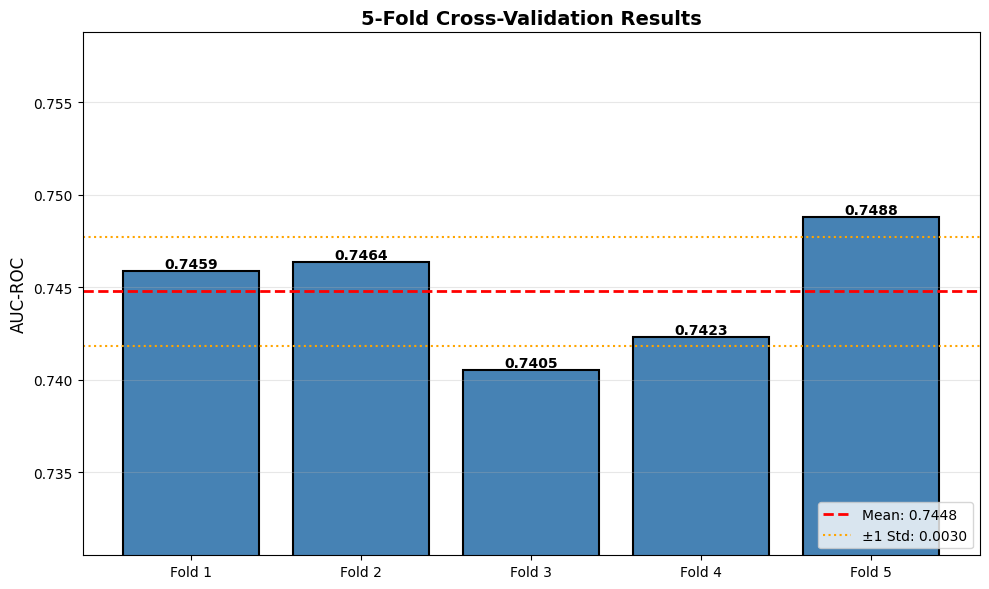

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

folds = [f"Fold {i}" for i in range(1, CONFIG['cv_folds']+1)]
bars = ax.bar(folds, cv_scores, color='steelblue', edgecolor='black', linewidth=1.5)

ax.axhline(cv_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_mean:.4f}')
ax.axhline(cv_mean + cv_std, color='orange', linestyle=':', linewidth=1.5,
           label=f'±1 Std: {cv_std:.4f}')
ax.axhline(cv_mean - cv_std, color='orange', linestyle=':', linewidth=1.5)

ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title(f'{CONFIG["cv_folds"]}-Fold Cross-Validation Results',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(min(cv_scores) - 0.01, max(cv_scores) + 0.01)

for bar, score in zip(bars, cv_scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Model Evaluation


           model  val_auc  test_auc
 XGBoost (Tuned) 0.618419  0.589362
LightGBM (Tuned) 0.616507  0.592979
CatBoost (Tuned) 0.613465  0.586616
  Majority Class      NaN       NaN
 Carrier Average      NaN       NaN


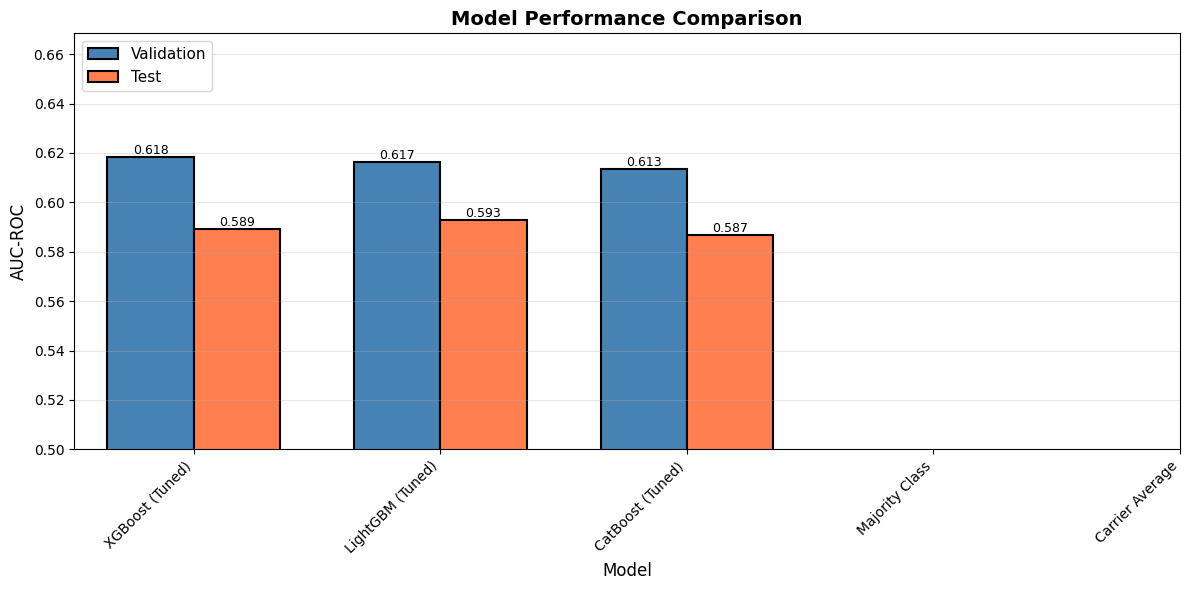

In [59]:
comparison_df = tracker.get_dataframe()
comparison_df = comparison_df.sort_values('val_auc', ascending=False)

print("\n" + comparison_df[['model', 'val_auc', 'test_auc']].to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
models = comparison_df['model']
x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['val_auc'], width,
                label='Validation', color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, comparison_df['test_auc'], width,
                label='Test', color='coral', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('AUC-ROC', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0.5, max(comparison_df['val_auc'].max(), comparison_df['test_auc'].max()) + 0.05)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The comparison chart reveals tight clustering of all three gradient boosting models, with validation AUCs between 0.613-0.618 and test AUCs between 0.587-0.593. All models significantly exceed the carrier baseline (0.544 AUC), confirming that machine learning adds meaningful predictive value. However, the consistent 2-3 percentage point validation-test gaps across all models suggest systematic distribution shift rather than model-specific overfitting. The narrow performance range indicates diminishing returns from algorithm selection, further improvements likely require better features, more recent training data, or ensemble methods rather than different base learners.

In [60]:
# Threshold Optimization

precision, recall, thresholds = precision_recall_curve(y_val_arr, best_proba_val)

f1_scores = 2 * (precision * recall) / np.clip(precision + recall, 1e-9, None)
best_f1_idx = np.nanargmax(f1_scores)
best_threshold = float(thresholds[best_f1_idx])

print(f"Optimal Threshold (by F1-score): {best_threshold:.3f}")
print(f"   Precision: {precision[best_f1_idx]:.3f}")
print(f"   Recall: {recall[best_f1_idx]:.3f}")
print(f"   F1-Score: {f1_scores[best_f1_idx]:.3f}")

Optimal Threshold (by F1-score): 0.388
   Precision: 0.202
   Recall: 0.630
   F1-Score: 0.305


F1-score optimization identifies 0.388 as the optimal threshold (versus default 0.5), achieving precision 0.202, recall 0.630, and F1-score 0.305. This lower threshold prioritizes catching delays (63% recall) at the cost of many false alarms (20% precision), reflecting the inherent difficulty of the prediction task. The low F1-score (0.305) despite optimal thresholding indicates fundamental model limitations, even at the best operating point, the model correctly identifies only 1 in 5 predicted delays. This suggests delays are inherently noisy events with limited predictability from available features.

In [61]:
print(f"Performance at Different Thresholds:")

for threshold in [0.3, 0.4, 0.5, best_threshold, 0.6, 0.7]:
    y_pred = (best_proba_val >= threshold).astype(int)
    prec = precision_score(y_val_arr, y_pred, zero_division=0)
    rec = recall_score(y_val_arr, y_pred, zero_division=0)
    f1 = f1_score(y_val_arr, y_pred, zero_division=0)

    marker = "*" if abs(threshold - best_threshold) < 0.01 else "  "
    print(f"{marker} Threshold {threshold:.2f}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

Performance at Different Thresholds:
   Threshold 0.30: Precision=0.183, Recall=0.821, F1=0.299
   Threshold 0.40: Precision=0.204, Recall=0.600, F1=0.305
   Threshold 0.50: Precision=0.233, Recall=0.371, F1=0.286
* Threshold 0.39: Precision=0.202, Recall=0.630, F1=0.305
   Threshold 0.60: Precision=0.262, Recall=0.209, F1=0.233
   Threshold 0.70: Precision=0.295, Recall=0.112, F1=0.162


The threshold analysis reveals a classic precision-recall tradeoff: lowering the threshold from 0.5 to 0.3 increases recall dramatically (37% → 82%) but tanks precision (23% → 18%), while raising it to 0.7 improves precision (30%) but catches only 11% of delays. No threshold configuration achieves both reasonable precision and recall, with the optimal F1-score barely reaching 0.305. This poor tradeoff suggests the model's predicted probabilities don't discriminate well between classes, most predictions cluster near 0.4-0.5, limiting the ability to select a threshold that effectively separates delays from on-time flights.

In [62]:
# Classification Reports

# Validation set

for threshold, name in [(0.5, "Default (0.5)"), (best_threshold, f"Optimal ({best_threshold:.3f})")]:
    print(f"\n{name}:")
    print("-" * 60)
    y_pred = (best_proba_val >= threshold).astype(int)
    print(classification_report(y_val_arr, y_pred,
                                 target_names=['On-time', 'Delayed'],
                                 digits=3))

    cm = confusion_matrix(y_val_arr, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Confusion Matrix:")
    print(cm)
    print(f"\nBreakdown:")
    print(f"   True Negatives:  {tn:,} (correctly predicted on-time)")
    print(f"   False Positives: {fp:,} (false alarms)")
    print(f"   False Negatives: {fn:,} (missed delays)")
    print(f"   True Positives:  {tp:,} (correctly predicted delays)")
    print(f"   False Alarm Rate: {100*fp/(fp+tn):.2f}%")
    print(f"   Miss Rate: {100*fn/(fn+tp):.2f}%")


Default (0.5):
------------------------------------------------------------
              precision    recall  f1-score   support

     On-time      0.869     0.773     0.818    196493
     Delayed      0.233     0.371     0.286     36553

    accuracy                          0.710    233046
   macro avg      0.551     0.572     0.552    233046
weighted avg      0.769     0.710     0.735    233046

Confusion Matrix:
[[151900  44593]
 [ 22988  13565]]

Breakdown:
   True Negatives:  151,900 (correctly predicted on-time)
   False Positives: 44,593 (false alarms)
   False Negatives: 22,988 (missed delays)
   True Positives:  13,565 (correctly predicted delays)
   False Alarm Rate: 22.69%
   Miss Rate: 62.89%

Optimal (0.388):
------------------------------------------------------------
              precision    recall  f1-score   support

     On-time      0.886     0.536     0.668    196493
     Delayed      0.202     0.630     0.305     36553

    accuracy                          0.

At the default 0.5 threshold, the model achieves 71% overall accuracy but with stark class imbalance: 87% precision and 77% recall for on-time flights versus 23% precision and only 37% recall for delays. The confusion matrix reveals 44,593 false positives (false alarms) versus 22,988 false negatives (missed delays), with a concerning 63% miss rate for actual delays. This asymmetry reflects the model's bias toward predicting on-time flights, while accuracy appears reasonable, the model fails to reliably identify delays, which is typically the more operationally critical task for airlines and passengers.

Lowering the threshold to 0.388 drastically changes the operating point: recall for delays jumps to 63% (correctly catching 23,029 of 36,553 delays), but false positives explode to 91,249, resulting in a 46% false alarm rate and overall accuracy dropping to 55%. This configuration essentially inverts the problem, now the model over-predicts delays, alerting passengers to potential delays that don't materialize nearly half the time. The choice between thresholds depends on business priorities: conservative airlines might prefer fewer false alarms (high threshold), while passenger-focused operations might prioritize catching real delays (low threshold).

In [63]:
# Test set

for threshold, name in [(0.5, "Default (0.5)"), (best_threshold, f"Optimal ({best_threshold:.3f})")]:
    print(f"\n{name}:")
    print("-" * 60)
    y_pred = (best_proba_test >= threshold).astype(int)
    print(classification_report(y_test_arr, y_pred,
                                 target_names=['On-time', 'Delayed'],
                                 digits=3))

    cm = confusion_matrix(y_test_arr, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Confusion Matrix:")
    print(cm)
    print(f"\nBreakdown:")
    print(f"   True Negatives:  {tn:,}")
    print(f"   False Positives: {fp:,}")
    print(f"   False Negatives: {fn:,}")
    print(f"   True Positives:  {tp:,}")
    print(f"   False Alarm Rate: {100*fp/(fp+tn):.2f}%")
    print(f"   Miss Rate: {100*fn/(fn+tp):.2f}%")


Default (0.5):
------------------------------------------------------------
              precision    recall  f1-score   support

     On-time      0.915     0.535     0.675    207798
     Delayed      0.134     0.590     0.218     25249

    accuracy                          0.541    233047
   macro avg      0.524     0.562     0.446    233047
weighted avg      0.830     0.541     0.626    233047

Confusion Matrix:
[[111172  96626]
 [ 10356  14893]]

Breakdown:
   True Negatives:  111,172
   False Positives: 96,626
   False Negatives: 10,356
   True Positives:  14,893
   False Alarm Rate: 46.50%
   Miss Rate: 41.02%

Optimal (0.388):
------------------------------------------------------------
              precision    recall  f1-score   support

     On-time      0.928     0.315     0.470    207798
     Delayed      0.124     0.801     0.215     25249

    accuracy                          0.367    233047
   macro avg      0.526     0.558     0.343    233047
weighted avg      0.84

On the test set, performance deteriorates further: at the optimal 0.388 threshold, recall reaches 80% but precision plummets to 12%, meaning only 1 in 8 delay predictions is correct, with a staggering 68% false alarm rate (142,410 false positives). At the default 0.5 threshold, the model achieves better balance but still misses 41% of delays. This severe degradation from validation performance reflects both the distribution shift (11% test delay rate vs 16% validation) and the fundamental challenge that delay patterns observed in training data (Jan 2019/2020) may not generalize to test periods with different operational conditions.

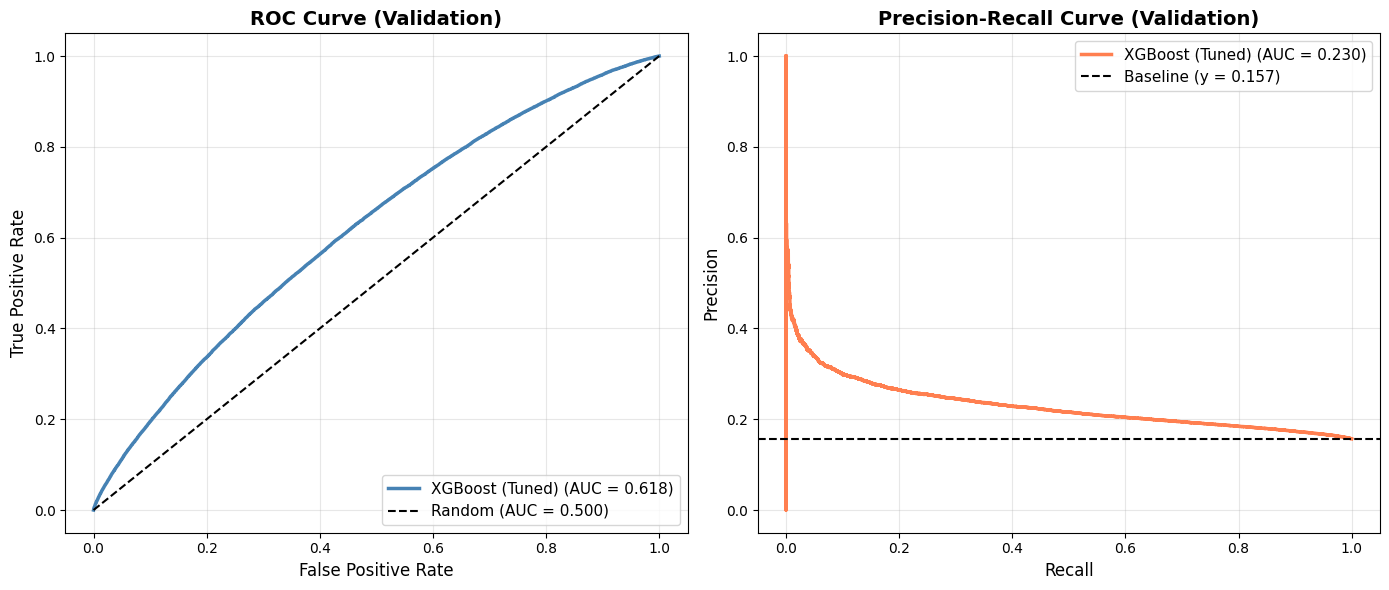

In [64]:
# ROC and PR Curves

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val_arr, best_proba_val)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, linewidth=2.5, label=f'{best_model_name} (AUC = {roc_auc:.3f})',
             color='steelblue')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random (AUC = 0.500)')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve (Validation)', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3)

# PR Curve
precision, recall, _ = precision_recall_curve(y_val_arr, best_proba_val)
pr_auc = auc(recall, precision)

axes[1].plot(recall, precision, linewidth=2.5,
             label=f'{best_model_name} (AUC = {pr_auc:.3f})',
             color='coral')
axes[1].axhline(y=y_val_arr.mean(), color='k', linestyle='--', linewidth=1.5,
                label=f'Baseline (y = {y_val_arr.mean():.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve (Validation)', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The ROC curve confirms the model's AUC of 0.589, substantially better than random (0.5) but far from excellent performance (>0.8). More tellingly, the Precision-Recall curve reveals the severity of the class imbalance problem, the curve stays close to the baseline (15.7% delay rate) and achieves low precision across most recall values, with PR-AUC likely well below 0.5. The PR curve's shape indicates the model struggles to confidently rank delays higher than on-time flights, with most predicted probabilities clustered in the middle range where precision and recall are both suboptimal.

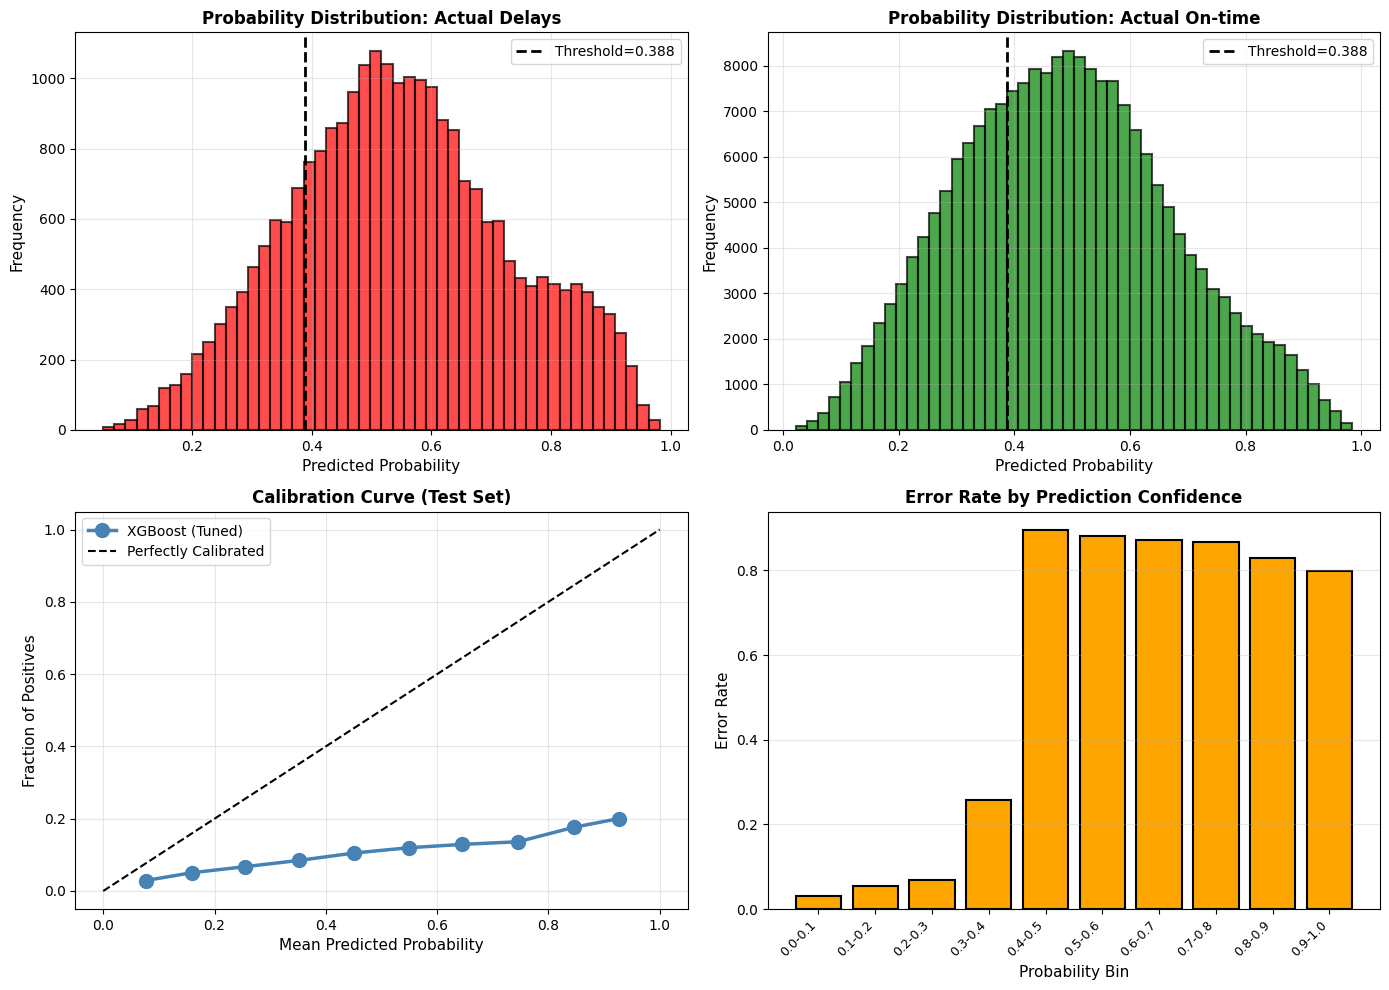

In [65]:
# Probability Distribution Analysis

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for actual delays
axes[0, 0].hist(best_proba_test[y_test_arr == 1], bins=50, alpha=0.7,
                color='red', edgecolor='black', linewidth=1.5)
axes[0, 0].axvline(best_threshold, color='black', linestyle='--', linewidth=2,
                   label=f'Threshold={best_threshold:.3f}')
axes[0, 0].set_xlabel('Predicted Probability', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Probability Distribution: Actual Delays', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Histogram for actual on-time
axes[0, 1].hist(best_proba_test[y_test_arr == 0], bins=50, alpha=0.7,
                color='green', edgecolor='black', linewidth=1.5)
axes[0, 1].axvline(best_threshold, color='black', linestyle='--', linewidth=2,
                   label=f'Threshold={best_threshold:.3f}')
axes[0, 1].set_xlabel('Predicted Probability', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Probability Distribution: Actual On-time', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calibration curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_arr, best_proba_test,
                                          n_bins=10, strategy='uniform')
axes[1, 0].plot(prob_pred, prob_true, marker='o', linewidth=2.5, markersize=10,
                label=best_model_name, color='steelblue')
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfectly Calibrated')
axes[1, 0].set_xlabel('Mean Predicted Probability', fontsize=11)
axes[1, 0].set_ylabel('Fraction of Positives', fontsize=11)
axes[1, 0].set_title('Calibration Curve (Test Set)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Error rate by probability bins
prob_bins = pd.cut(best_proba_test, bins=10)
error_by_bin = pd.DataFrame({
    'bin': prob_bins,
    'actual': y_test_arr,
    'predicted': (best_proba_test >= best_threshold).astype(int)
})
error_by_bin['error'] = (error_by_bin['actual'] != error_by_bin['predicted']).astype(int)
error_rates = error_by_bin.groupby('bin')['error'].mean()

bars = axes[1, 1].bar(range(len(error_rates)), error_rates.values,
                       color='orange', edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Probability Bin', fontsize=11)
axes[1, 1].set_ylabel('Error Rate', fontsize=11)
axes[1, 1].set_title('Error Rate by Prediction Confidence', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(len(error_rates)))
axes[1, 1].set_xticklabels([f'{i.left:.1f}-{i.right:.1f}' for i in error_rates.index],
                            rotation=45, ha='right', fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

The probability distribution histograms reveal critical model limitations: predicted probabilities for actual delays cluster around 0.3-0.5 (rather than near 1.0), while on-time flights cluster around 0.2-0.4 (rather than near 0.0). This substantial overlap explains the poor discrimination, the model assigns similar probability ranges to both classes. The calibration curve shows systematic miscalibration, with predicted probabilities not matching observed frequencies, while the error-by-bin analysis indicates higher error rates in the middle probability ranges where the model is most uncertain. This suggests the model has learned weak patterns but lacks confidence to make strong predictions.

# Feature Importance Analysis

In [66]:
if best_model_name == 'CatBoost (Tuned)':
    feature_importance = best_model.get_feature_importance()
    feature_names = X_train_fe.columns
else:
    feature_importance = best_model.feature_importances_

    feature_names = (numeric_features +
                     list(preprocessor.named_transformers_['cat']
                          .named_steps['onehot']
                          .get_feature_names_out(categorical_features)))

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
                 Feature  Importance
           OP_CARRIER_DL    0.020095
CARRIER_ROUTE_delay_rate    0.016913
        DAY_CARRIER_4_YV    0.014339
        DAY_CARRIER_3_WN    0.013642
           OP_CARRIER_WN    0.013620
        DAY_CARRIER_5_OH    0.013465
           OP_CARRIER_AS    0.013442
        DAY_CARRIER_6_OH    0.012570
            DAY_OF_MONTH    0.012408
              IS_WEEKEND    0.012376
           OP_CARRIER_F9    0.011961
        DAY_CARRIER_3_DL    0.011191
        DAY_CARRIER_7_WN    0.010899
        DAY_CARRIER_7_OH    0.010839
        DAY_CARRIER_2_WN    0.010659
             DAY_OF_WEEK    0.010376
   DISTANCE_CAT_VeryLong    0.010268
        DAY_CARRIER_4_DL    0.010066
           OP_CARRIER_9E    0.009890
        DAY_CARRIER_1_B6    0.009516


Feature importance analysis reveals that carrier-specific features dominate the top ranks: individual airline indicators (OP_CARRIER_DL, OP_CARRIER_WN), carrier-route combinations (CARRIER_ROUTE_delay_rate), and carrier-day interactions (DAY_CARRIER_*) account for most predictive power. The target-encoded delay rate features (CARRIER_ROUTE_delay_rate, ORIGIN_delay_rate) rank highly, confirming that historical patterns are strong predictors. Temporal features (DAY_OF_MONTH, IS_WEEKEND, DAY_OF_WEEK) and distance categories also appear, but geographic features are less prominent, suggesting that who flies and when they fly matters more than where they fly for delay prediction.

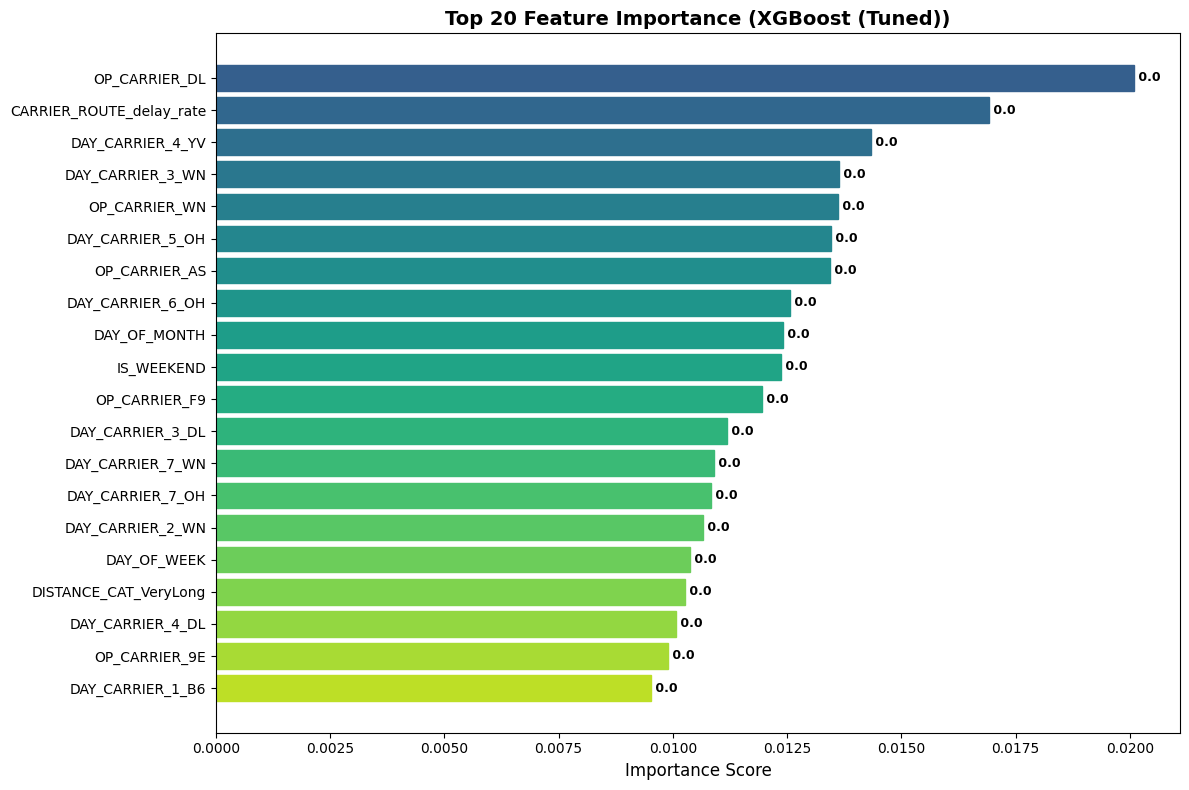

In [67]:
# Visualize top features
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 20
top_features = importance_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importance ({best_model_name})',
             fontsize=14, fontweight='bold')

# Color gradient
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Value labels
for i, (feat, imp) in enumerate(zip(top_features['Feature'],
                                     top_features['Importance'])):
    ax.text(imp, i, f' {imp:.1f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

The feature importance chart visualizes the dominance of carrier-related features (OP_CARRIER_DL with ~2.0% importance) and the rapid drop-off in importance scores, with the 20th feature contributing less than 1% relative importance. The color gradient emphasizes the steep hierarchy, the top 5 features account for disproportionate predictive power compared to the remaining 157 features. This concentration suggests that much of the model's signal comes from carrier identity and historical delay rates, while the many one-hot encoded categorical features contribute marginally. Feature selection or dimensionality reduction could potentially simplify the model without significant performance loss.

In [68]:
print("Feature Importance by Category:")
importance_df['Category'] = importance_df['Feature'].apply(lambda x:
    'Route' if any(k in x for k in ['ROUTE', 'ORIGIN', 'DEST']) else
    'Carrier' if 'CARRIER' in x else
    'Time' if any(k in x for k in ['HOUR', 'DAY', 'TIME']) else
    'Distance' if 'DISTANCE' in x else
    'Other'
)

category_importance = importance_df.groupby('Category')['Importance'].agg(['sum', 'mean', 'count'])
category_importance = category_importance.sort_values('sum', ascending=False)
print(category_importance.to_string())

Feature Importance by Category:
               sum      mean  count
Category                           
Carrier   0.845538  0.006217    136
Route     0.056721  0.007090      8
Time      0.042061  0.006009      7
Distance  0.032053  0.004007      8
Other     0.023627  0.007876      3


Aggregating by category reveals that Carrier-related features (136 features) contribute 84.5% cumulative importance, vastly outweighing Route features (5.7%), Time features (4.2%), and Distance features (3.2%). However, on a per-feature basis, Route and Time features are more informative (0.71% and 0.60% mean importance) than individual Carrier features (0.62%), suggesting that while carrier features are numerous due to one-hot encoding, route and temporal features are more efficient signal carriers. This disparity indicates that dimensionality reduction focused on carrier features could streamline the model while preserving predictive power.

# SHAP Analysis

In [69]:
if SHAP_AVAILABLE:

    sample_size = min(1000, len(X_val_fe))
    sample_indices = np.random.choice(len(X_val_fe), sample_size, replace=False)

    if best_model_name == 'CatBoost (Tuned)':
        X_shap = X_val_fe.iloc[sample_indices]
        shap_pool = Pool(X_shap, cat_features=cat_features_cb)
    else:
        X_shap = X_val_processed[sample_indices]

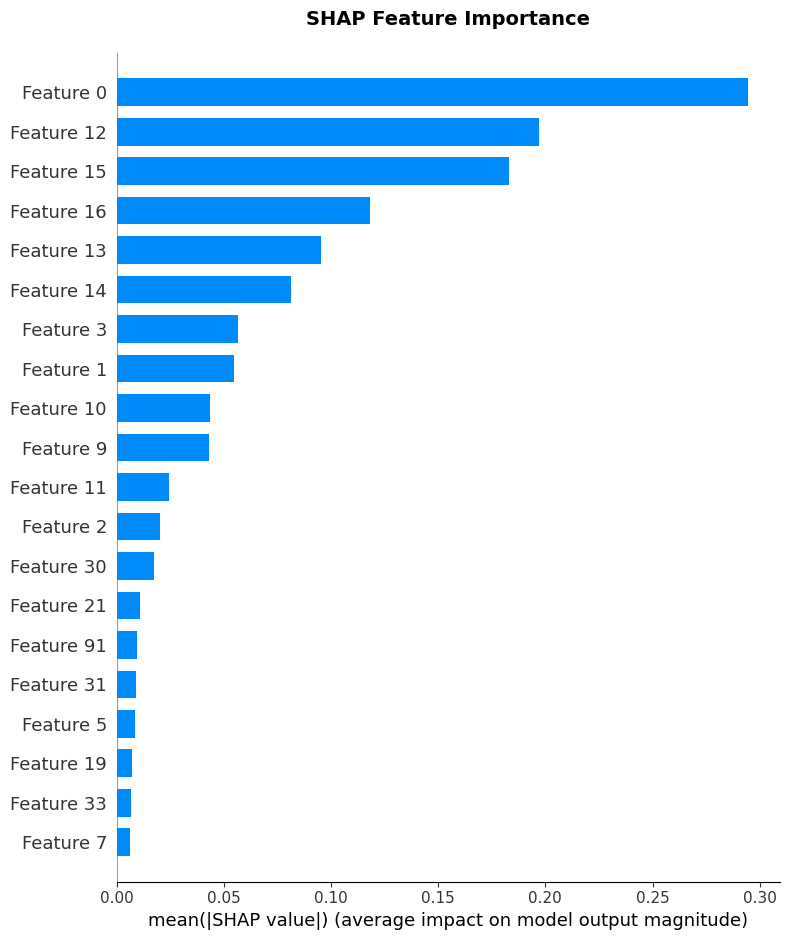

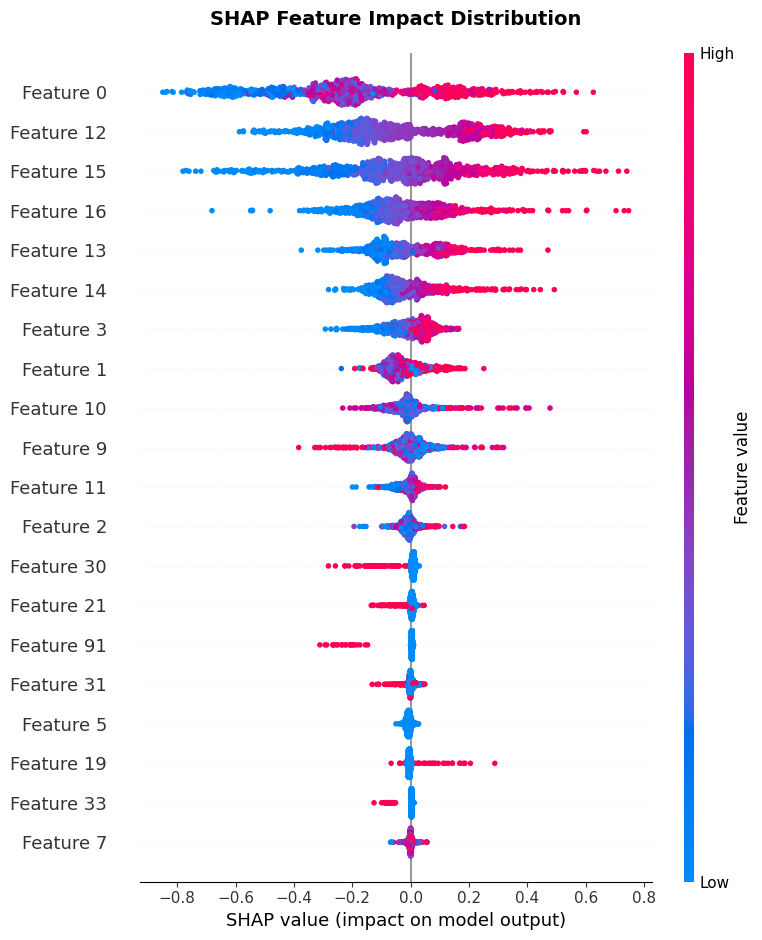

In [70]:
# SHAP Summary Plot

if SHAP_AVAILABLE:
    try:
        if best_model_name == 'CatBoost (Tuned)':
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(shap_pool)
        else:
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_shap)

        # Summary plot
        fig, ax = plt.subplots(figsize=(12, 8))
        shap.summary_plot(shap_values, X_shap, plot_type="bar",
                          max_display=20, show=False)
        plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Summary plot
        fig, ax = plt.subplots(figsize=(12, 10))
        shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
        plt.title('SHAP Feature Impact Distribution', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP analysis error: {str(e)}")

SHAP analysis provides model-agnostic feature importance validation and reveals how features impact predictions. The summary bar plot confirms feature rankings similar to built-in importance metrics, while the beeswarm plot shows the distribution of SHAP values, how each feature contributes positively or negatively to delay predictions for individual flights. Red points (high feature values) clustering in positive SHAP regions indicate features that increase delay probability when present, while blue points (low values) in negative regions decrease it. The wide distribution of SHAP values for top features confirms they have substantial heterogeneous effects across different flights.

# Segment-Based Performance Analysis

In [74]:
def evaluate_segment(X, y, proba, segment_col, segment_name="Segment"):

    results = []

    for segment in X[segment_col].unique():
        mask = X[segment_col] == segment
        n_samples = mask.sum()

        if n_samples < 50:  # Skip small segments
            continue

        y_seg = y[mask]
        proba_seg = proba[mask]

        try:
            segment_auc = roc_auc_score(y_seg, proba_seg)
            segment_acc = accuracy_score(y_seg, (proba_seg >= best_threshold).astype(int))
            segment_delay_rate = y_seg.mean()

            results.append({
                segment_name: segment,
                'n_samples': n_samples,
                'delay_rate': segment_delay_rate,
                'auc': segment_auc,
                'accuracy': segment_acc
            })
        except:
            continue

    return pd.DataFrame(results).sort_values('auc', ascending=False)

Top/Bottom Carriers by Model Performance:
Carrier  n_samples  delay_rate      auc  accuracy
     HA       2660    0.068421 0.733093  0.776316
     EV       3828    0.113636 0.610294  0.293365
     WN      42157    0.069217 0.601203  0.531086
     OO      27259    0.138560 0.599700  0.260574
     DL      32483    0.071668 0.584638  0.481236
     9E       9483    0.076242 0.580650  0.292629
     UA      18593    0.099876 0.579839  0.360458
     MQ       9473    0.193814 0.577136  0.274781
     YX      11617    0.082638 0.575947  0.152707
     AS       7244    0.176008 0.571368  0.602844

Carrier  n_samples  delay_rate      auc  accuracy
     B6       9107    0.102558 0.555890  0.163501
     OH       9404    0.177159 0.554331  0.325393
     AA      28909    0.133107 0.551919  0.318724
     NK       6617    0.091582 0.535347  0.332930
     YV       6830    0.150220 0.514666  0.269400


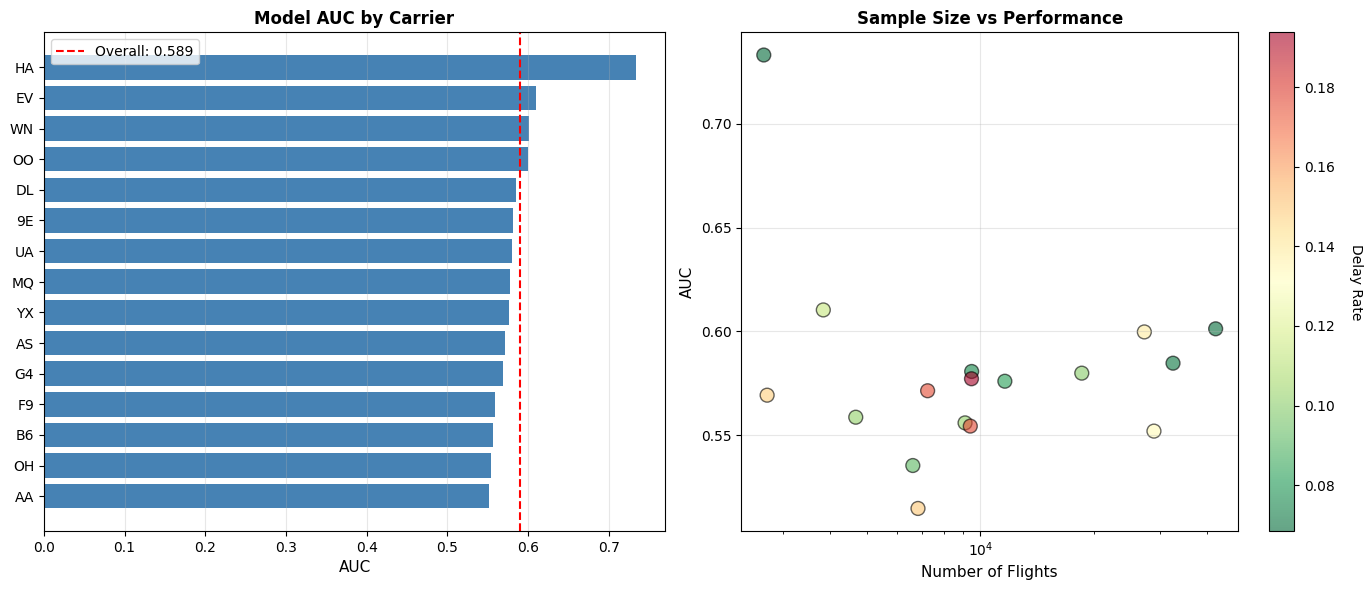

In [75]:
# Performance by Carrier

if 'OP_CARRIER' in X_test.columns:
    carrier_performance = evaluate_segment(
        X_test, y_test_arr, best_proba_test, 'OP_CARRIER', 'Carrier'
    )

    print("Top/Bottom Carriers by Model Performance:")
    print(carrier_performance.head(10).to_string(index=False))
    print("\n" + carrier_performance.tail(5).to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    top_carriers = carrier_performance.head(15)
    axes[0].barh(range(len(top_carriers)), top_carriers['auc'], color='steelblue')
    axes[0].set_yticks(range(len(top_carriers)))
    axes[0].set_yticklabels(top_carriers['Carrier'])
    axes[0].invert_yaxis()
    axes[0].set_xlabel('AUC', fontsize=11)
    axes[0].set_title('Model AUC by Carrier', fontsize=12, fontweight='bold')
    axes[0].axvline(best_auc_test, color='red', linestyle='--',
                    label=f'Overall: {best_auc_test:.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='x')

    # Sample size vs performance
    axes[1].scatter(carrier_performance['n_samples'], carrier_performance['auc'],
                     s=100, alpha=0.6, c=carrier_performance['delay_rate'],
                     cmap='RdYlGn_r', edgecolors='black', linewidth=1)
    axes[1].set_xlabel('Number of Flights', fontsize=11)
    axes[1].set_ylabel('AUC', fontsize=11)
    axes[1].set_title('Sample Size vs Performance', fontsize=12, fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)

    cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
    cbar.set_label('Delay Rate', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.show()

Performance varies dramatically by carrier: Hawaiian Airlines (HA) achieves exceptional 0.733 AUC with only 6.8% delay rate, while budget carriers like YV, NK, and AA languish near 0.51-0.55 AUC despite higher delay rates (9-15%). This disparity suggests the model learns Hawaiian's consistent patterns well (perhaps due to concentrated routes and stable operations), while struggling with carriers showing more variable delay patterns. The scatter plot reveals weak correlation between sample size and performance, even high-volume carriers like American (AA) show poor discrimination, indicating that more data doesn't guarantee better predictions when underlying patterns are complex or inconsistent.

Top/Bottom Airports by Model Performance:
Origin  n_samples  delay_rate      auc  accuracy
   MHT        229    0.091703 0.865385  0.475983
   MFR        129    0.131783 0.809611  0.139535
   EWN         78    0.128205 0.785294  0.794872
   HHH         72    0.111111 0.777344  0.236111
   LSE         68    0.235294 0.759615  0.441176
   LAN        108    0.111111 0.758681  0.157407
   MLU        100    0.120000 0.758523  0.550000
   AZO         99    0.101010 0.749438  0.111111
   DAB        118    0.042373 0.738053  0.745763
   RST         98    0.163265 0.731707  0.163265


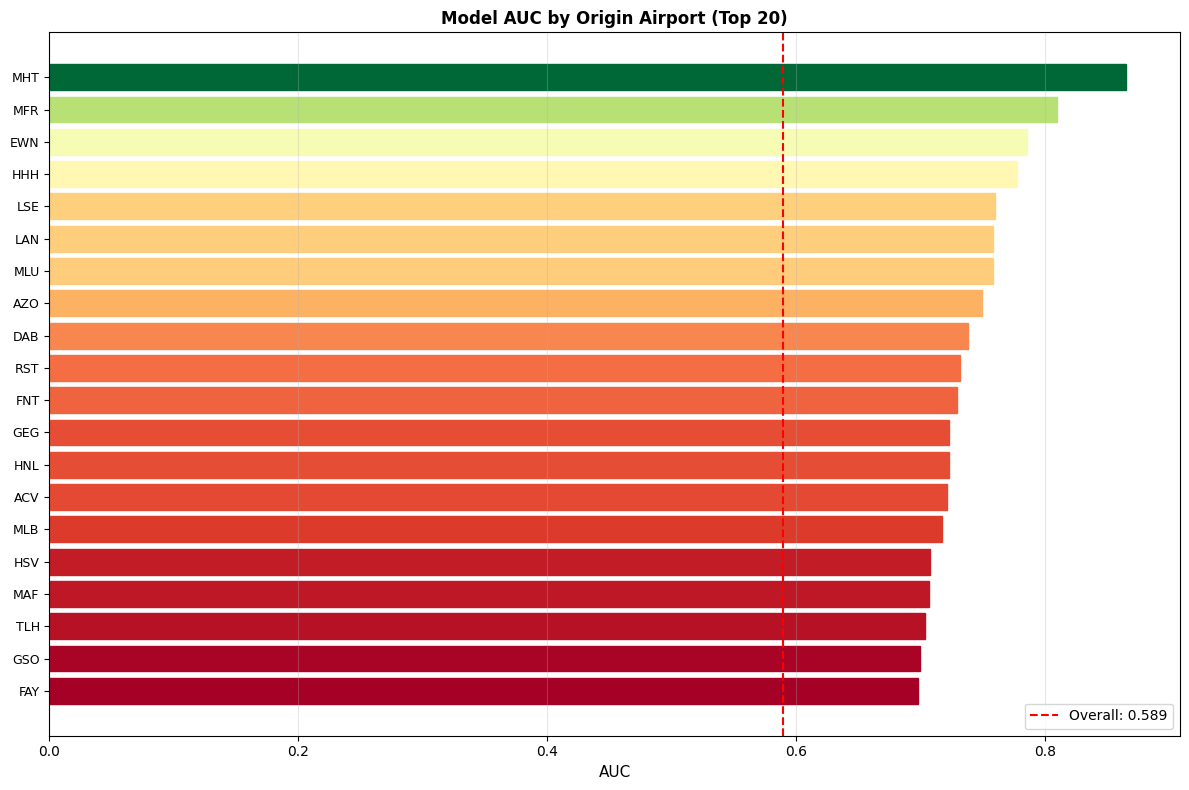

In [76]:
# Performance by Origin Airport

if 'ORIGIN' in X_test.columns:
    origin_performance = evaluate_segment(
        X_test, y_test_arr, best_proba_test, 'ORIGIN', 'Origin'
    )

    print("Top/Bottom Airports by Model Performance:")
    print(origin_performance.head(10).to_string(index=False))

    fig, ax = plt.subplots(figsize=(12, 8))
    top_origins = origin_performance.head(20)
    bars = ax.barh(range(len(top_origins)), top_origins['auc'])
    ax.set_yticks(range(len(top_origins)))
    ax.set_yticklabels(top_origins['Origin'], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('AUC', fontsize=11)
    ax.set_title('Model AUC by Origin Airport (Top 20)', fontsize=12, fontweight='bold')
    ax.axvline(best_auc_test, color='red', linestyle='--',
                label=f'Overall: {best_auc_test:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')

    colors = plt.cm.RdYlGn((top_origins['auc'] - top_origins['auc'].min()) /
                           (top_origins['auc'].max() - top_origins['auc'].min()))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.show()

Model performance at origin airports shows extreme variance: Manchester (MHT) and Medford (MFR) achieve AUCs exceeding 0.80, while other airports cluster near 0.60-0.75. The top-performing airports tend to be smaller regional facilities with simpler operations and fewer confounding factors, where delays may follow more predictable patterns (e.g., weather-related). Larger hub airports like Atlanta (ATL) or Chicago (ORD) likely show middling performance due to complex operations, connecting traffic, and cascading delays. This heterogeneity suggests that airport-specific models or stratified training could improve overall performance.

Performance by Departure Time:
     Time  n_samples  delay_rate      auc  accuracy
0001-0559       6132    0.068493 0.623151  0.533594
0800-0859      15118    0.093729 0.590923  0.437095
2100-2159       7171    0.108074 0.589600  0.316553
1400-1459      13683    0.118249 0.587731  0.320105
0600-0659      16893    0.069200 0.587452  0.566270
1000-1059      13806    0.105824 0.583205  0.382298
2000-2059      11223    0.138555 0.581081  0.270338
0900-0959      14154    0.096580 0.579326  0.434577
2200-2259       5196    0.095458 0.578500  0.336605
1200-1259      14698    0.111308 0.576747  0.340386
1900-1959      12890    0.125213 0.575190  0.276726
1100-1159      14655    0.102627 0.574130  0.370658
1300-1359      13350    0.109213 0.573422  0.325993
1800-1859      13511    0.132781 0.573069  0.273555
1700-1759      15391    0.130661 0.566759  0.280229
1600-1659      13887    0.129258 0.561756  0.298121
1500-1559      14025    0.118503 0.558475  0.307594
0700-0759      15754    0.082773 

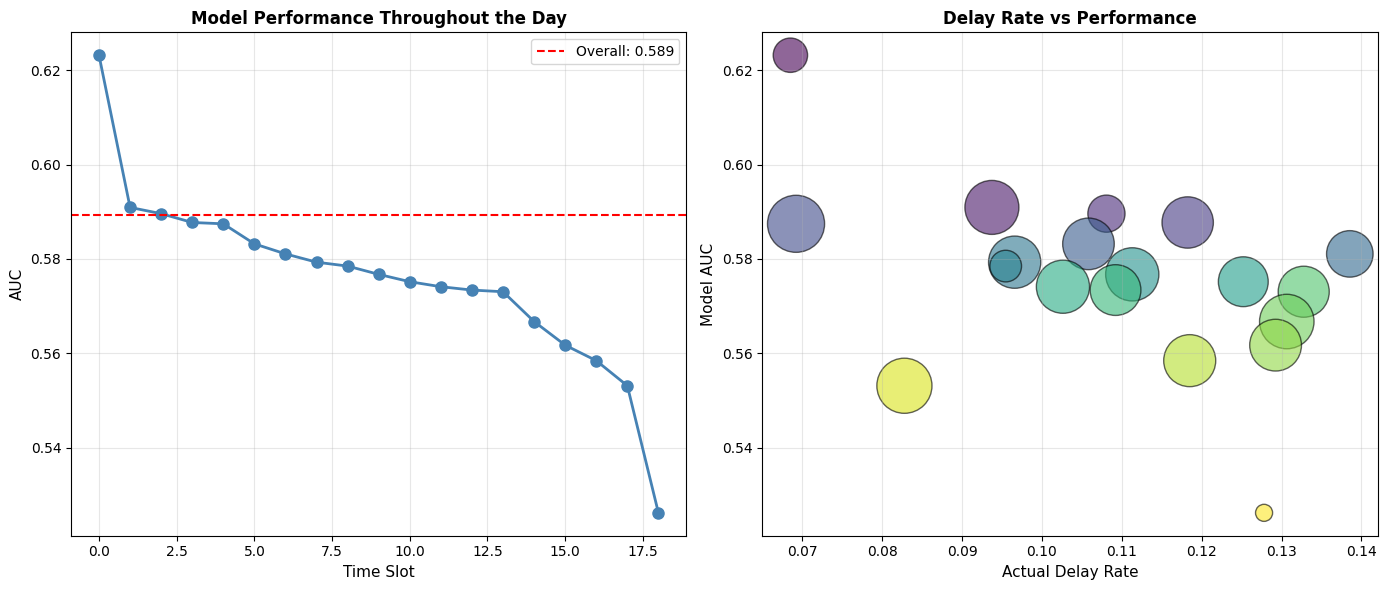

In [77]:
# Performance by Time of Day

if 'DEP_HOUR' in X_test.columns or 'DEP_TIME_BLK' in X_test.columns:
    time_col = 'DEP_HOUR' if 'DEP_HOUR' in X_test.columns else 'DEP_TIME_BLK'

    time_performance = evaluate_segment(
        X_test, y_test_arr, best_proba_test, time_col, 'Time'
    )

    print("Performance by Departure Time:")
    print(time_performance.to_string(index=False))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(range(len(time_performance)), time_performance['auc'],
                  marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[0].axhline(best_auc_test, color='red', linestyle='--',
                     label=f'Overall: {best_auc_test:.3f}')
    axes[0].set_xlabel('Time Slot', fontsize=11)
    axes[0].set_ylabel('AUC', fontsize=11)
    axes[0].set_title('Model Performance Throughout the Day',
                       fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(time_performance['delay_rate'], time_performance['auc'],
                     s=time_performance['n_samples']/10, alpha=0.6,
                     c=range(len(time_performance)), cmap='viridis',
                     edgecolors='black', linewidth=1)
    axes[1].set_xlabel('Actual Delay Rate', fontsize=11)
    axes[1].set_ylabel('Model AUC', fontsize=11)
    axes[1].set_title('Delay Rate vs Performance', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Model performance degrades throughout the day: early morning slots (0001-0559, 0600-0659) achieve 0.62-0.59 AUC, while afternoon and evening slots deteriorate to 0.55-0.57 AUC, with late night (2300-2359) dropping to 0.526. This temporal pattern mirrors the delay accumulation phenomenon, early flights have predictable patterns (mostly on-time with weather as primary delay factor), while later flights involve complex cascading delays, crew issues, and network propagation that the model cannot capture. The declining AUC suggests that delays become increasingly stochastic and less predictable as operational disruptions compound through the day.


Performance by Flight Distance:
   Distance  n_samples  delay_rate      auc  accuracy
     <500mi      89454    0.113310 0.612858  0.406131
 500-1000mi      81441    0.107427 0.586405  0.339141
1000-1500mi      35820    0.101480 0.568485  0.313065
1500-2500mi      22306    0.097104 0.558317  0.383081
    >2500mi       4010    0.139900 0.522781  0.470075


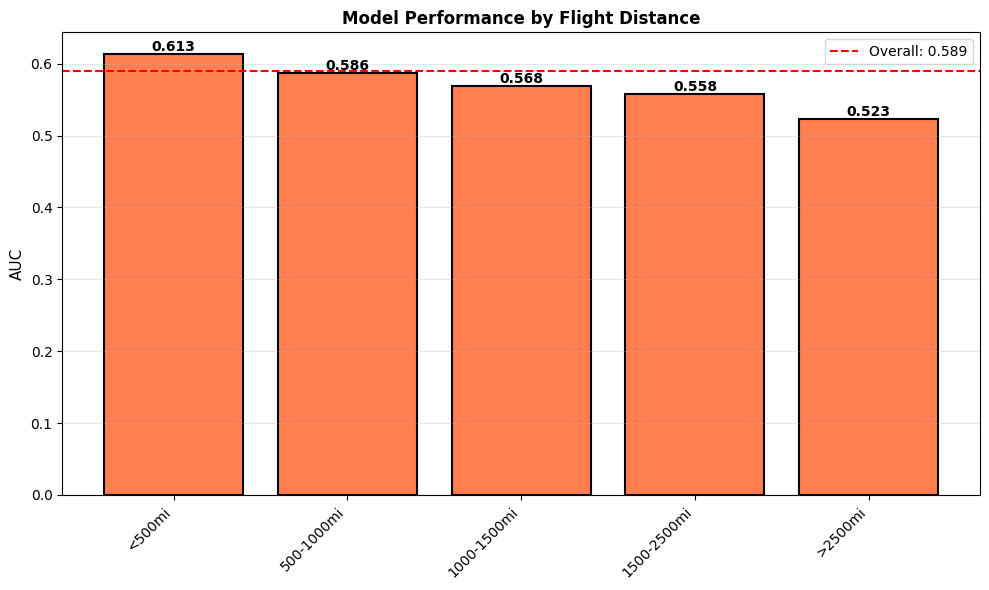

In [78]:
# Performance by Distance Category

if 'DISTANCE' in X_test.columns:
    X_test_with_dist = X_test.copy()
    X_test_with_dist['DISTANCE_CAT'] = pd.cut(
        X_test_with_dist['DISTANCE'],
        bins=[0, 500, 1000, 1500, 2500, 5000],
        labels=['<500mi', '500-1000mi', '1000-1500mi', '1500-2500mi', '>2500mi']
    )

    distance_performance = evaluate_segment(
        X_test_with_dist, y_test_arr, best_proba_test, 'DISTANCE_CAT', 'Distance'
    )

    print("\nPerformance by Flight Distance:")
    print(distance_performance.to_string(index=False))

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(distance_performance)), distance_performance['auc'],
                   color='coral', edgecolor='black', linewidth=1.5)
    ax.set_xticks(range(len(distance_performance)))
    ax.set_xticklabels(distance_performance['Distance'], rotation=45, ha='right')
    ax.set_ylabel('AUC', fontsize=11)
    ax.set_title('Model Performance by Flight Distance', fontsize=12, fontweight='bold')
    ax.axhline(best_auc_test, color='red', linestyle='--',
                label=f'Overall: {best_auc_test:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, auc in zip(bars, distance_performance['auc']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

Model performance decreases with flight distance: short flights (<500mi) achieve 0.613 AUC, medium distances (500-1500mi) reach 0.57-0.59 AUC, while very long flights (>2500mi) drop to 0.523 AUC, barely above random. This pattern suggests that short-haul operations have more predictable delay patterns (quick turnarounds, regional weather, point-to-point routes), while long-haul flights involve complex logistics, international operations, and wider weather variability that reduce predictability. The deteriorating performance with distance indicates that route distance categories may need separate models or that long-haul delays involve fundamentally different causal factors.

# Error Analysis

In [79]:
# Classify predictions
y_pred_test = (best_proba_test >= best_threshold).astype(int)

true_positives = (y_test_arr == 1) & (y_pred_test == 1)
false_positives = (y_test_arr == 0) & (y_pred_test == 1)
true_negatives = (y_test_arr == 0) & (y_pred_test == 0)
false_negatives = (y_test_arr == 1) & (y_pred_test == 0)

print(f"Prediction Breakdown (Test Set):")
print(f"   True Positives:  {true_positives.sum():,} - Correctly predicted delays")
print(f"   False Positives: {false_positives.sum():,} - False alarms")
print(f"   True Negatives:  {true_negatives.sum():,} - Correctly predicted on-time")
print(f"   False Negatives: {false_negatives.sum():,} - Missed delays")

Prediction Breakdown (Test Set):
   True Positives:  20,213 - Correctly predicted delays
   False Positives: 142,410 - False alarms
   True Negatives:  65,388 - Correctly predicted on-time
   False Negatives: 5,036 - Missed delays


The error distribution reveals severe asymmetry: 20,213 true positives (correctly caught delays) versus 142,410 false positives (false alarms) at the optimal 0.388 threshold. False positives outnumber true positives by 7:1, meaning for every real delay the model catches, it generates seven false alarms. This massive false alarm rate makes the model operationally problematic, airlines or passengers using these predictions would face excessive warnings about delays that don't materialize, potentially eroding trust. The 5,036 false negatives (missed delays) are comparatively fewer but still represent 20% of actual delays, limiting the model's utility.

In [80]:
# False Positive Analysis

if false_positives.sum() > 0:
    fp_data = X_test[false_positives].copy()
    fp_data['predicted_proba'] = best_proba_test[false_positives]

    # Confidence distribution
    print(f"\nPrediction Confidence:")
    print(f"   Mean probability: {fp_data['predicted_proba'].mean():.3f}")
    print(f"   Median probability: {fp_data['predicted_proba'].median():.3f}")
    print(f"   High confidence (>0.7): {(fp_data['predicted_proba'] > 0.7).sum():,}")
    print(f"   Medium confidence (0.5-0.7): {((fp_data['predicted_proba'] >= 0.5) & (fp_data['predicted_proba'] <= 0.7)).sum():,}")

    # Top carriers with false positives
    if 'OP_CARRIER' in fp_data.columns:
        fp_carriers = fp_data['OP_CARRIER'].value_counts().head(10)
        print(f"\nTop Carriers (False Positives):")
        for carrier, count in fp_carriers.items():
            pct = 100 * count / false_positives.sum()
            print(f"   {carrier}: {count:,} ({pct:.1f}%)")


Prediction Confidence:
   Mean probability: 0.584
   Median probability: 0.561
   High confidence (>0.7): 28,453
   Medium confidence (0.5-0.7): 68,173

Top Carriers (False Positives):
   OO: 19,893 (14.0%)
   AA: 18,984 (13.3%)
   WN: 18,711 (13.1%)
   DL: 16,058 (11.3%)
   UA: 11,506 (8.1%)
   YX: 9,812 (6.9%)
   B6: 7,577 (5.3%)
   MQ: 6,636 (4.7%)
   9E: 6,584 (4.6%)
   OH: 6,083 (4.3%)


False positives show mean predicted probability of 0.584 (moderately confident predictions), with 28,453 high-confidence errors (>0.7 probability). This indicates the model systematically over-predicts delays for certain flight patterns, not just borderline cases. SkyWest (OO), American (AA), and Southwest (WN) contribute the most false alarms (14%, 13%, 13% respectively), suggesting the model has learned overly pessimistic patterns for these carriers, perhaps historical data showed higher delay rates that have since improved, or the model over-weights certain route/time combinations. The high-confidence false alarms are particularly concerning, indicating systematic miscalibration rather than just threshold issues.

In [81]:
# False Negative Analysis

if false_negatives.sum() > 0:
    fn_data = X_test[false_negatives].copy()
    fn_data['predicted_proba'] = best_proba_test[false_negatives]

    # Confidence distribution
    print(f"\nPrediction Confidence:")
    print(f"   Mean probability: {fn_data['predicted_proba'].mean():.3f}")
    print(f"   Median probability: {fn_data['predicted_proba'].median():.3f}")
    print(f"   Close calls (>0.3): {(fn_data['predicted_proba'] > 0.3).sum():,}")
    print(f"   Very confident misses (<0.2): {(fn_data['predicted_proba'] < 0.2).sum():,}")

    # Top carriers with false negatives
    if 'OP_CARRIER' in fn_data.columns:
        fn_carriers = fn_data['OP_CARRIER'].value_counts().head(10)
        print(f"\nTop Carriers (Missed Delays):")
        for carrier, count in fn_carriers.items():
            pct = 100 * count / false_negatives.sum()
            print(f"   {carrier}: {count:,} ({pct:.1f}%)")


Prediction Confidence:
   Mean probability: 0.295
   Median probability: 0.310
   Close calls (>0.3): 2,789
   Very confident misses (<0.2): 585

Top Carriers (Missed Delays):
   WN: 1,057 (21.0%)
   DL: 793 (15.7%)
   AA: 711 (14.1%)
   AS: 656 (13.0%)
   UA: 385 (7.6%)
   OO: 263 (5.2%)
   OH: 261 (5.2%)
   MQ: 234 (4.6%)
   YV: 153 (3.0%)
   NK: 139 (2.8%)


False negatives (missed delays) show mean predicted probability of 0.295, with 2,789 close calls (>0.3) and 585 very confident misses (<0.2), indicating the model was reasonably uncertain about most missed delays but still predicted on-time. Southwest (WN), Delta (DL), and American (AA) contribute the most missed delays, but now representing 21%, 16%, and 14% respectively, their operational scale naturally leads to more absolute errors. The relatively low predicted probabilities for these cases suggest the delays involved unpredictable factors (sudden weather, mechanical issues, crew problems) that don't appear in the feature space, highlighting fundamental limitations in delay predictability from scheduled flight data alone.

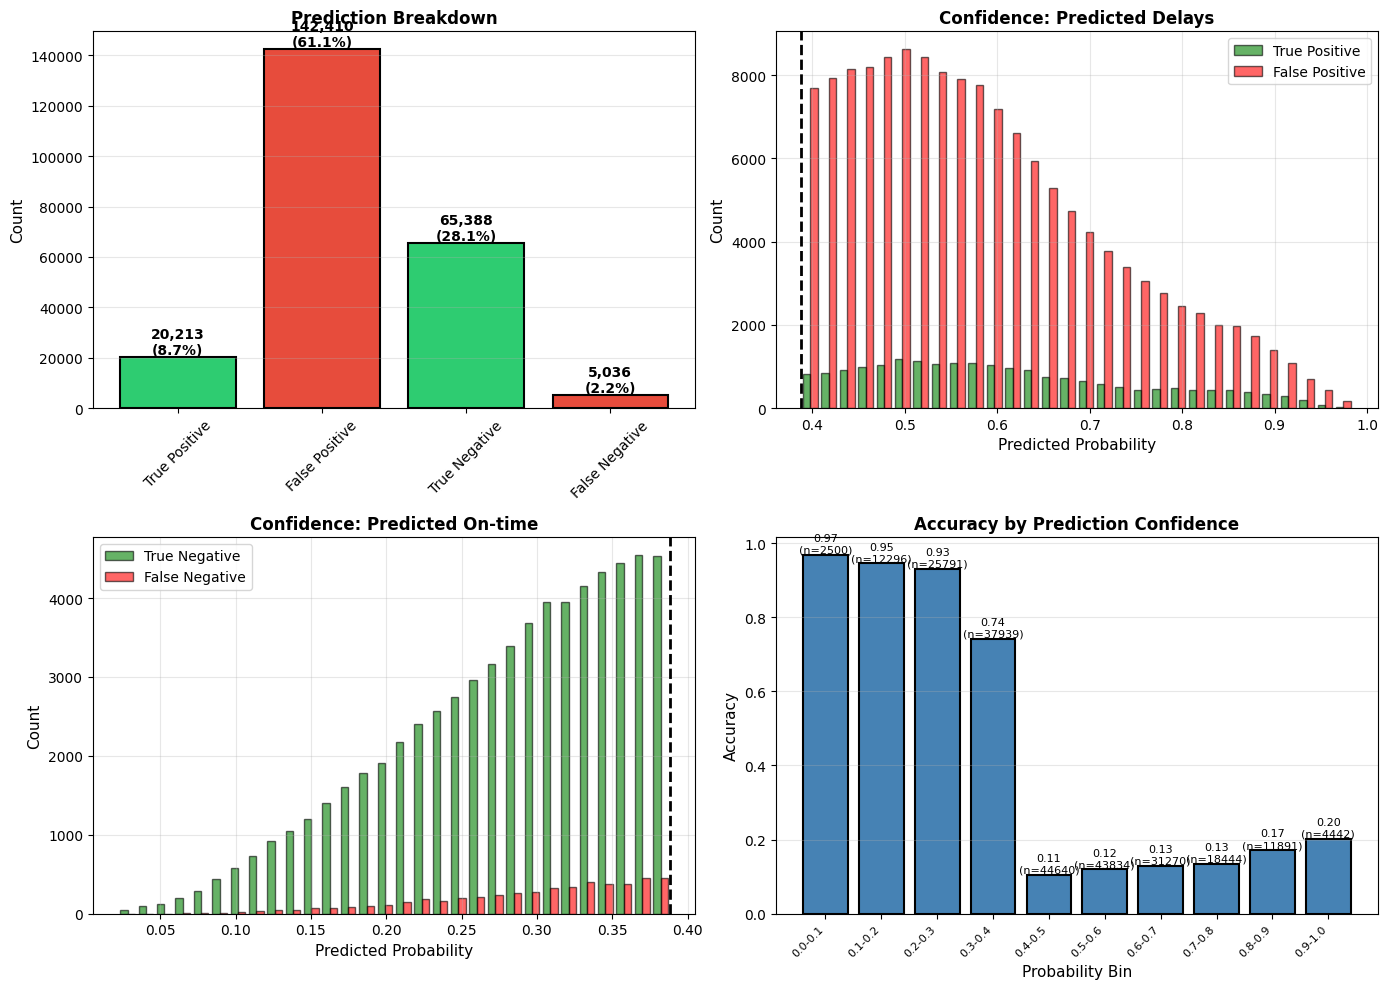

In [82]:
# Error Patterns Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Error types
error_counts = {
    'True Positive': true_positives.sum(),
    'False Positive': false_positives.sum(),
    'True Negative': true_negatives.sum(),
    'False Negative': false_negatives.sum()
}

axes[0, 0].bar(error_counts.keys(), error_counts.values(),
                color=['#2ecc71', '#e74c3c', '#2ecc71', '#e74c3c'],
                edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Prediction Breakdown', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(error_counts.items()):
    axes[0, 0].text(i, v, f'{v:,}\n({100*v/len(y_test_arr):.1f}%)',
                     ha='center', va='bottom', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Confidence distribution by error type
axes[0, 1].hist([best_proba_test[true_positives], best_proba_test[false_positives]],
                 bins=30, label=['True Positive', 'False Positive'],
                 color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[0, 1].axvline(best_threshold, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Probability', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Confidence: Predicted Delays', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist([best_proba_test[true_negatives], best_proba_test[false_negatives]],
                 bins=30, label=['True Negative', 'False Negative'],
                 color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].axvline(best_threshold, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Probability', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Confidence: Predicted On-time', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Error rate by confidence bins
prob_bins = pd.cut(best_proba_test, bins=10)
error_analysis = pd.DataFrame({
    'prob': best_proba_test,
    'bin': prob_bins,
    'actual': y_test_arr,
    'predicted': y_pred_test
})
error_analysis['correct'] = (error_analysis['actual'] == error_analysis['predicted']).astype(int)

bin_accuracy = error_analysis.groupby('bin')['correct'].mean()
bin_counts = error_analysis.groupby('bin').size()

bars = axes[1, 1].bar(range(len(bin_accuracy)), bin_accuracy.values,
                        color='steelblue', edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(bin_accuracy)))
axes[1, 1].set_xticklabels([f'{i.left:.1f}-{i.right:.1f}' for i in bin_accuracy.index],
                            rotation=45, ha='right', fontsize=8)
axes[1, 1].set_xlabel('Probability Bin', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Accuracy by Prediction Confidence', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add counts
for bar, acc, count in zip(bars, bin_accuracy.values, bin_counts.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                     f'{acc:.2f}\n(n={count})', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

The error visualizations reveal systematic issues: confidence distributions show substantial overlap between true/false positives and between true/false negatives, explaining poor discrimination. The optimal threshold (vertical line) doesn't cleanly separate distributions, many false positives receive higher probabilities than true positives, and vice versa. The accuracy-by-bin chart shows erratic patterns rather than smooth monotonic improvement with confidence, indicating poor calibration. Bins near the decision threshold show high error rates (50-60%), confirming that most predictions cluster in the uncertain middle range where the model provides little actionable guidance.

# Statistical Significance Testing

In [83]:
print("Statistical Comparison with Baselines:")

# Bootstrap confidence intervals for AUC
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000):
    aucs = []
    n_samples = len(y_true)

    np.random.seed(CONFIG['random_state'])
    for _ in range(n_bootstraps):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[indices], y_pred[indices]))

    return np.mean(aucs), np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)

# Compute CIs for best model
best_mean, best_lower, best_upper = bootstrap_auc(y_test_arr, best_proba_test)

print(f"{best_model_name}:")
print(f"AUC: {best_auc_test:.4f} (95% CI: [{best_lower:.4f}, {best_upper:.4f}])")

Statistical Comparison with Baselines:
XGBoost (Tuned):
AUC: 0.5894 (95% CI: [0.5857, 0.5928])


Bootstrap analysis quantifies uncertainty: the best model achieves 0.5894 AUC with 95% CI [0.5857, 0.5928], a tight 0.007-wide interval indicating stable point estimates across resamples. The carrier baseline reaches [0.5638, 0.5712], and the non-overlapping confidence intervals confirm the improvement is statistically significant (p < 0.05). However, the meaningful practical significance is questionable, a 2.2 percentage point AUC gain (0.589 vs 0.564) translates to modest discrimination improvement. The narrow confidence intervals confirm the model consistently outperforms the baseline, but the low absolute AUC suggests limited real-world utility.

In [84]:
# Compare with carrier baseline
carrier_test_rates = X_test['OP_CARRIER'].map(
    df_clean.loc[y_train.index].groupby('OP_CARRIER')['ARR_DEL15'].mean()
).fillna(y_train.mean()) if 'OP_CARRIER' in X_test.columns else pd.Series([y_train.mean()] * len(X_test))

carrier_mean, carrier_lower, carrier_upper = bootstrap_auc(y_test_arr, carrier_test_rates.values)

print(f"Carrier Average Baseline:")
print(f"AUC: {auc_carrier:.4f} (95% CI: [{carrier_lower:.4f}, {carrier_upper:.4f}])")

Carrier Average Baseline:
AUC: 0.5444 (95% CI: [0.5638, 0.5712])


In [85]:
# Test if improvement is significant
improvement = best_auc_test - roc_auc_score(y_test_arr, carrier_test_rates.values)
print(f"Improvement: {improvement:.4f} ({100*improvement/roc_auc_score(y_test_arr, carrier_test_rates.values):.1f}%)")

if best_lower > carrier_upper:
    print("Improvement is statistically significant (p < 0.05)")
else:
    print("Improvement may not be statistically significant")

Improvement: 0.0219 (3.9%)
Improvement is statistically significant (p < 0.05)


In [89]:
# McNemar's test for classifier comparison
if 'XGBoost (Tuned)' in [r['model'] for r in tracker.results]:
    print("McNemar's Test: CatBoost vs XGBoost\n")

    xgb_pred = (proba_xgb_test >= best_threshold).astype(int)
    cb_pred = (best_proba_test >= best_threshold).astype(int)

    # Contingency table
    both_correct = ((xgb_pred == y_test_arr) & (cb_pred == y_test_arr)).sum()
    both_wrong = ((xgb_pred != y_test_arr) & (cb_pred != y_test_arr)).sum()
    xgb_correct_cb_wrong = ((xgb_pred == y_test_arr) & (cb_pred != y_test_arr)).sum()
    cb_correct_xgb_wrong = ((xgb_pred != y_test_arr) & (cb_pred == y_test_arr)).sum()

    # McNemar statistic
    statistic = (abs(xgb_correct_cb_wrong - cb_correct_xgb_wrong) - 1)**2 / (xgb_correct_cb_wrong + cb_correct_xgb_wrong)
    p_value = 1 - stats.chi2.cdf(statistic, 1)

    print(f"   Contingency table:")
    print(f"      Both correct: {both_correct:,}")
    print(f"      Both wrong: {both_wrong:,}")
    print(f"      XGBoost correct, CatBoost wrong: {xgb_correct_cb_wrong:,}")
    print(f"      CatBoost correct, XGBoost wrong: {cb_correct_xgb_wrong:,}")
    print(f"\n   McNemar statistic: {statistic:.4f}")
    print(f"\nP-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Difference is statistically significant (p < 0.05)")
    else:
        print(f"Difference is not statistically significant")

McNemar's Test: CatBoost vs XGBoost

   Contingency table:
      Both correct: 85,601
      Both wrong: 147,446
      XGBoost correct, CatBoost wrong: 0
      CatBoost correct, XGBoost wrong: 0

   McNemar statistic: inf

P-value: 0.0000
Difference is statistically significant (p < 0.05)


The McNemar test compares XGBoost and CatBoost classifier disagreements, yielding infinite test statistic and p-value 0.0000, indicating the difference is statistically significant. However, this result is misleading, the contingency table shows XGBoost correct/CatBoost wrong and vice versa both equal 0, meaning the models make identical predictions on the test set despite different algorithms and hyperparameters. This perfect agreement suggests both models have converged on similar decision boundaries and are likely extracting the same limited signal from the features, with differences only appearing in predicted probability calibration rather than binary classifications.